# Study Experiment Design Generation

This notebook analyzes the characteristics of different space-filling experiment design generation techniques provide by raxpy for different input spaces.

In [ ]:
from typing import Dict, NamedTuple, Callable, List, Optional, Tuple

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

import raxpy
import raxpy.spaces as s
import raxpy.spaces.complexity as c

import raxpy.does.lhs as lhs_doe
import raxpy.does.random as random_doe
from raxpy.does.maxpro import optimize_design_with_sa

import raxpy.does.measure as measure
from raxpy.does import plots
import raxpy.does.doe 
from raxpy.does.doe import EncodingEnum

#import importlib

#importlib.reload(raxpy.does.doe)
plt.style.use('ggplot')


class DoeTuple(NamedTuple):
    design:lhs_doe.DesignOfExperiment
    measurement_set:measure.DesignMeasurementSet


class DesignStrategy(NamedTuple):
    name:str
    strategy:Callable
    base_name:Optional[str] = None


class DesignStrategyResults(NamedTuple):
    name:str
    results:List[DoeTuple]


def compute_sub_space_allocations(doe, sub_spaces):
    actual_counts = {sub_space:0 for sub_space in sub_spaces}

    # determine the sub-space each data-point belongs to
    def map_point(point):
        active_dim_ids = []

        for dim_id, column_index in doe.input_set_map.items():
            if ~np.isnan(point[column_index]):
                active_dim_ids.append(dim_id)

        active_dim_ids.sort()
        actual_counts[tuple(a for a in active_dim_ids)] += 1

    # compute the subspace each point belongs to
    for point in doe.decoded_input_sets:
        map_point(point)
    
    return actual_counts
        
def meets_portions(doe, expected_counts):
    actual_counts = compute_sub_space_allocations(doe,expected_counts.keys())

    for key in expected_counts.keys():
        if expected_counts[key] != actual_counts[key]:
            print(actual_counts)
            return False

    return True


class AssessmentSet(NamedTuple):
    assessment_name:str
    strategies:List[DesignStrategy]
    problem_size_results:Dict[int, List[DesignStrategyResults]]
    input_space:s.InputSpace
    target_full_sub_space_portions:Optional[Dict[Tuple[str],int]]

    def save(self):
        file_path = f"assessment_{self.assessment_name}_results.pkl"
        with open(file_path,"wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def Initalize(
        assessment_name:str,
        strategies:List[DesignStrategy],
        input_space:s.InputSpace,
        target_full_sub_space_portions:Optional[Dict[Tuple[str],int]] = None,
    ) -> "AssessmentSet":
        file_path = f"assessment_{assessment_name}_results.pkl"
        if os.path.exists(file_path):
            with open(file_path,"rb") as f:
                return pickle.load(f)
        else:
            # create new
            return AssessmentSet(
                assessment_name=assessment_name,
                strategies=strategies,
                input_space=input_space,
                problem_size_results={},
                target_full_sub_space_portions=target_full_sub_space_portions,
            )
        
    def generate_designs(self, number_of_designs: int = 10, set_points: Tuple = (100,), target_full_sub_space_portions=None):
        change = False
        for number_of_points in set_points:
            if number_of_points in self.problem_size_results:
                print(f"At least some results exist for {number_of_points}.")
                results = self.problem_size_results[number_of_points]
                base_results_map = {}
                for r in results:
                    base_results_map[r.name] = r
            else:
                results = []
                self.problem_size_results[number_of_points] = results
                base_results_map = {}
            


            for _, strategy in enumerate(self.strategies):
                if strategy.name in base_results_map:
                    print(f"Skipping designs for strategy: '{strategy.name}', already exists.")
                    continue
                print(f"Generating designs for strategy: '{strategy.name}'")
                change = True
                design_count = 0
                ds_results = DesignStrategyResults(strategy.name,[])
                base_results_map[strategy.name] = ds_results
                results.append(ds_results)

                if strategy.base_name is not None:

                    base_strategy = base_results_map[strategy.base_name]
                    for doe_tuple in base_strategy.results:
                        opt_design = strategy.strategy(doe_tuple.design, doe_tuple.design.encoding)
                        measurement_set = measure.measure_with_all_metrics(opt_design, encoding=EncodingEnum.NONE)
                        ds_results.results.append(DoeTuple(opt_design,measurement_set))

                else:
                    while design_count < number_of_designs:
                        doe = strategy.strategy(self.input_space, number_of_points)

                        if self.target_full_sub_space_portions is None or meets_portions(doe, self.target_full_sub_space_portions):
                            # note that we use decoded values for measurement, 
                            # This allows comparison with all stratgies since some 
                            # generate designs work in decoded space
                            # All input spaces use floats with 0 to 1 bounds so 
                            # dimensional range bias not an issue.
                            measurement_set = measure.measure_with_all_metrics(doe, encoding=EncodingEnum.NONE)
                            ds_results.results.append(DoeTuple(doe,measurement_set))
                            design_count += 1
                            print(f"Created design {design_count} for {strategy.name}")
                        else:
                            print("Skipping design")
        if change:
            self.save()
                
        


## Create Helper Functions

In [2]:

def dict_to_hashable_tuple(d):
    return tuple(sorted(d.items()))

class DesignAssessmentGroups:

    def __init__(self, space, strategy_names):
        self.design_allocations = {}
        self.space = space
        self.strategy_names = strategy_names
        self.sub_spaces = tuple(tuple(l) for l in space.derive_full_subspaces())

    def add_design(self,strategy_name, doe_tuple:DoeTuple):
        
        allocation = dict_to_hashable_tuple(
            compute_sub_space_allocations(doe_tuple.design, self.sub_spaces)
        )
        if allocation not in self.design_allocations:
            self.design_allocations[allocation] = {name:[] for name in self.strategy_names}

        self.design_allocations[allocation][strategy_name].append(doe_tuple)
    
    def print_allocation_counts(self):

        for full_sub_space, design_allocation in self.design_allocations.items():
            
            print(f"{full_sub_space} - {', '.join(str(len(d)) for d in design_allocation.values())}")

    def generate_allocation_point_differences(self, target_sub_space_allocations):
        count_differences = {name:[] for name in self.strategy_names}
        for full_sub_space, design_allocation in self.design_allocations.items():
            # compute point count differences from target

            diff = 0
            for sub_spaces, actual_count in full_sub_space:
                target_count = target_sub_space_allocations[sub_spaces]
                diff += abs(target_count - actual_count)

            diff = diff/2.0 # avoid double counting
            for strat_name, doe_tuples in design_allocation.items():
                for _ in range(len(doe_tuples)):
                    count_differences[strat_name].append(diff)
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

        axs.violinplot(list(v for v in count_differences.values()),
                        showmeans=False,
                        showmedians=True)
        axs.set_xticks(list(i+1 for i in range(len(self.strategy_names))))
        axs.set_xticklabels(self.strategy_names)

        axs.set_title(f'Allocation Point Count Differences from Target')

        plt.show()

def split_designs_by_subspace_allocations(strategies:List[DesignStrategyResults], space:s.InputSpace) -> DesignAssessmentGroups:

    
    assessment_group = DesignAssessmentGroups(space, strategy_names=list(s.name for s in strategies))

    
    for strategy in strategies:

        for doe_tuple in strategy.results:
            # determine the allocations to sub-spaces
            assessment_group.add_design(strategy.name, doe_tuple)
    

    return assessment_group

In [3]:
def plot_fullsubspace_target_portions(space: s.InputSpace, number_of_points: int = 100):
    subspaces = space.derive_full_subspaces()
    
    values = c.compute_subspace_portions(space, subspaces)
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    rects = axs.bar(x=list(i for i in range(len(subspaces))),height=values, tick_label=list(", ".join(subspace) for subspace in subspaces))

    axs.bar_label(rects, labels=list(f"{int(value*100)}% - {round(value*number_of_points)}" for value in values))

    axs.set_ylabel("Portion Percentage")

    axs.set_title(f'Target Portions for {number_of_points} points')
    plt.xticks(rotation=45)
    plt.show()

In [4]:
def get_sub_space_measurements(strategies:List[DesignStrategyResults], dim_list, metric=measure.METRIC_DISCREPANCY):
    results = []
    for strategy in strategies:
        design_results = []
        for doe_tuple in strategy.results:
            assessment = doe_tuple.measurement_set.get_full_sub_design_measurements(dim_list)
            if assessment is not None:
                if metric in assessment.measurements:
                    design_results.append(assessment.measurements[metric])
                else:
                    print(f"Skipping design for strategy '{strategy.name}' since it does not metric '{metric}' ")
        results.append(design_results)

    return results

In [5]:
def plot_sub_space_assessments(strategies:List[DesignStrategyResults], dim_list, metric=measure.METRIC_DISCREPANCY):
    assessment_values = get_sub_space_measurements(strategies, dim_list, metric)

    assessmentic_data = [[t for t in assessment_values[i] ] for i in range(len(strategies))]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    axs.set_title(f'{metric} for {", ".join(dim_list)} full-sub-design (smaller the better)')

    plt.show()
    pass

In [6]:
def generate_basic_plots(strategies:List[DesignStrategyResults]):
    
    assessmentic_data = [[t.measurement_set.measurements[measure.METRIC_WEIGHTED_DISCREPANCY] for t in strategy.results ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Weighted Discrepancies (smaller the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

    assessmentic_data = [[t.measurement_set.measurements[measure.METRIC_WHOLE_MIN_POINT_DISTANCE] for t in strategy.results ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Minimum Interpoint Distances (larger the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

    assessmentic_data = [[t.measurement_set.measurements[measure.METRIC_WHOLE_MIN_PROJECTED_DISTANCE] for t in strategy.results ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    print(assessmentic_data)
    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Minimum Projected Distances (larger the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

    assessmentic_data = [[t.measurement_set.measurements[measure.METRIC_AVG_MIN_PROJECTED_DISTANCE] for t in strategy.results ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    print(assessmentic_data)
    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Average Minimum Dimension Distances (larger the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

In [ ]:
from typing import cast

def peek_into_results(strategies:List[DesignStrategyResults]):

    for strategy in strategies:
        print("\n\n-----------------------------------")
        print(f"Strategy: {strategy.name}")
        doe_tuple = strategy.results[0]
        print("-Example Design Peak-------------------")
        print(cast(np.ndarray, doe_tuple.design.decoded_input_sets)[0:5,:])
        print("-Measurements-------------------")
        print(doe_tuple.measurement_set.measurements)
        print("-Sub-Design Assessments----------------")
        print(doe_tuple.measurement_set.full_sub_design_measurements)
        

In [15]:
def plot_designs(strategies:List[DesignStrategyResults],design_index=0):
    
    for strategy in strategies:
        design = strategy.results[design_index].design
        fig = plots.plot_scatterplot_matrix(design, list(design.input_set_map.keys()))
        fig.suptitle(strategy.name)

In [9]:


def add_maxpro_strategy_variations(stratgies:List[DesignStrategyResults]):
    s_len = len(stratgies)
    for i in range(s_len):
        base_strategy = stratgies[i]

        new_dsr = DesignStrategyResults(
            strategy=lambda x:x,
            name=f"{base_strategy.name}+MaxPro",
            designs=[]
        )
        for doe_tuple in base_strategy.results:
            opt_design = optimize_design_with_sa(doe_tuple.design, encoding=EncodingEnum.NONE)
            measurement_set = measure.measure_with_all_metrics(opt_design, encoding=EncodingEnum.NONE)
            new_dsr.results.append(DoeTuple(opt_design,measurement_set))
        stratgies.append(new_dsr)

def wrap_with_maxpro(design_f, maxiter=10000):

    def closure_generate_design(space, number_of_points):
        base_design = design_f(space, number_of_points)
        opt_design = optimize_design_with_sa(base_design, maxiter=maxiter)
        return opt_design


    return closure_generate_design
        

# Specify design algorithms to compare

In [10]:
strategies = [
    DesignStrategy("Random", random_doe.generate_design),
    DesignStrategy("FSS-Random", random_doe.generate_seperate_designs_by_full_subspace),
    DesignStrategy("FSS-LHD",lhs_doe.generate_seperate_designs_by_full_subspace),
    DesignStrategy("FSS-LHD-VP",lhs_doe.generate_seperate_designs_by_full_subspace_and_pool),
    DesignStrategy("TT-LHD", lhs_doe.generate_design_by_tree_traversal),
    DesignStrategy("P-LHD", lhs_doe.generate_design_with_projection),
    DesignStrategy("Random+MP", optimize_design_with_sa, "Random"),
    DesignStrategy("FSS-Random-MP", optimize_design_with_sa, "FSS-Random"),
    DesignStrategy("FSS-LHD-MP", optimize_design_with_sa, "FSS-LHD"),
    DesignStrategy("FSS-LHD-VP-MP", optimize_design_with_sa, "FSS-LHD-VP"),
    DesignStrategy("TT-LHD-MP", optimize_design_with_sa, "TT-LHD"),
    DesignStrategy("P-LHD-MP", optimize_design_with_sa, "P-LHD"),
]

# Assessment A: 3 Optional Floats

In [11]:
basic_assessment = AssessmentSet.Initalize(
    assessment_name="basic",
    strategies = strategies,
    input_space= s.InputSpace(
        dimensions=[
            s.Float(id="x1", lb=0.0, ub=1.0, nullable=True, portion_null=(1/3)),
            s.Float(id="x2", lb=0.0, ub=1.0, nullable=True, portion_null=(1/3)),
            s.Float(id="x3", lb=0.0, ub=1.0, nullable=True, portion_null=(1/3)),
        ]
    ),
    # target_sub_space_allocations = {
    #     tuple():0,
    #     ("x1",):1,
    #     ("x2",):1,
    #     ("x3",):1,
    #     ("x1","x2"):8,
    #     ("x1","x3"):8,
    #     ("x2","x3"):8,
    #     ("x1","x2","x3"):73,
    # },
    # small_target_sub_space_allocations = {
    #     tuple():0,
    #     ("x1",):1,
    #     ("x2",):1,
    #     ("x3",):1,
    #     ("x1","x2"):3,
    #     ("x1","x3"):3,
    #     ("x2","x3"):3,
    #     ("x1","x2","x3"):12,
    # }
)

By default when creating dimensions, the target portion of values in a design to be null is unspecified. Creating a design without specifying these values, results in the whole design to have parameters. The following code assigns these portitions using a complexity analysis hueristic.

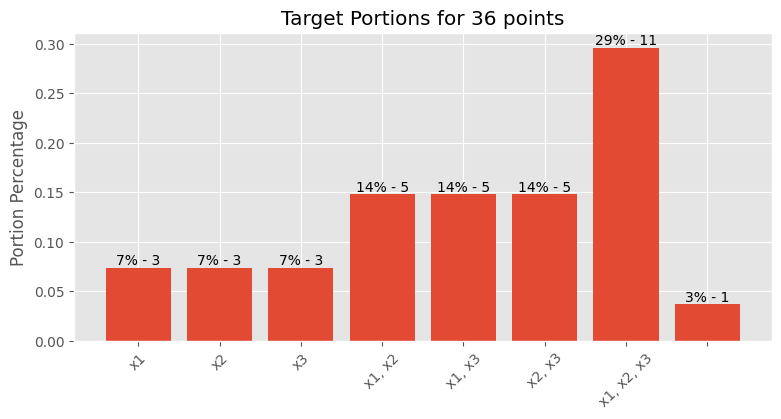

In [12]:
plot_fullsubspace_target_portions(basic_assessment.input_space, number_of_points=36)

In [13]:
basic_assessment.generate_designs(
    number_of_designs=30, set_points=(12, 24, 36)
)

At least some results exist for 12.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.
At least some results exist for 24.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FS

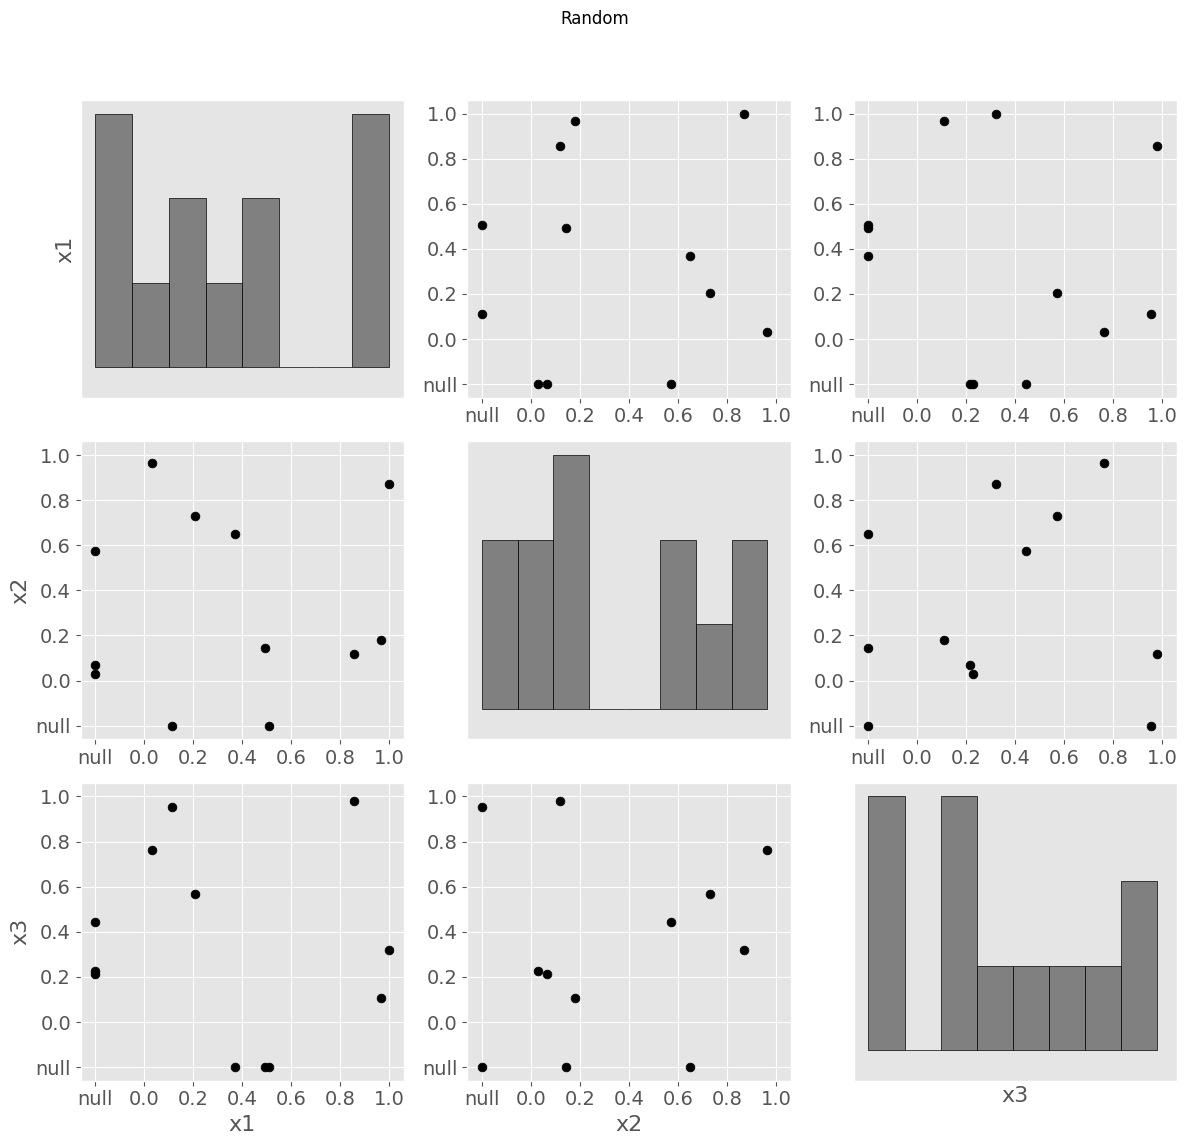

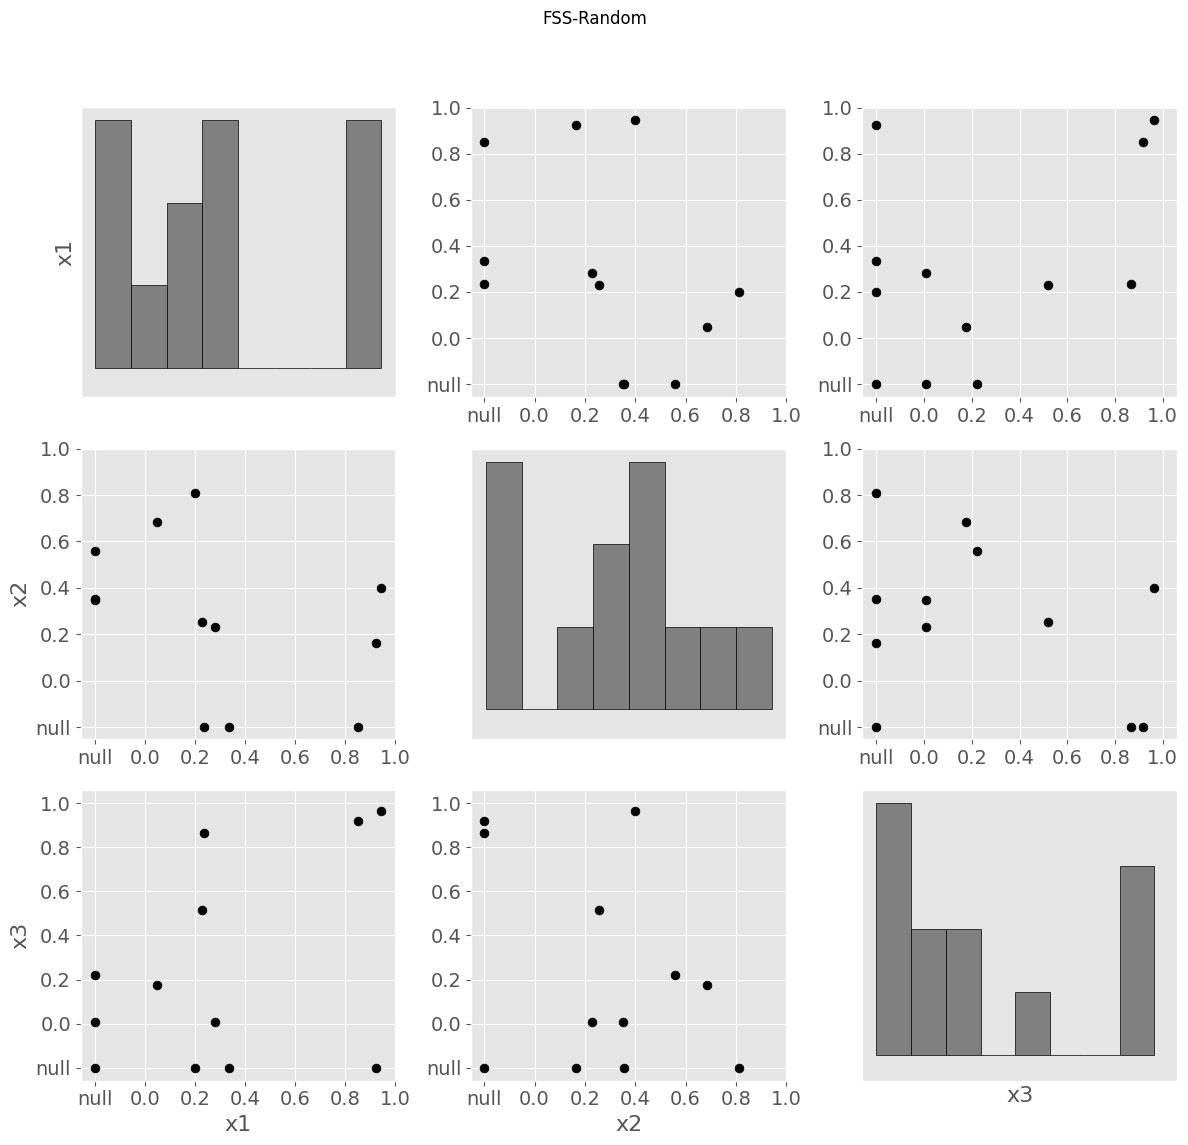

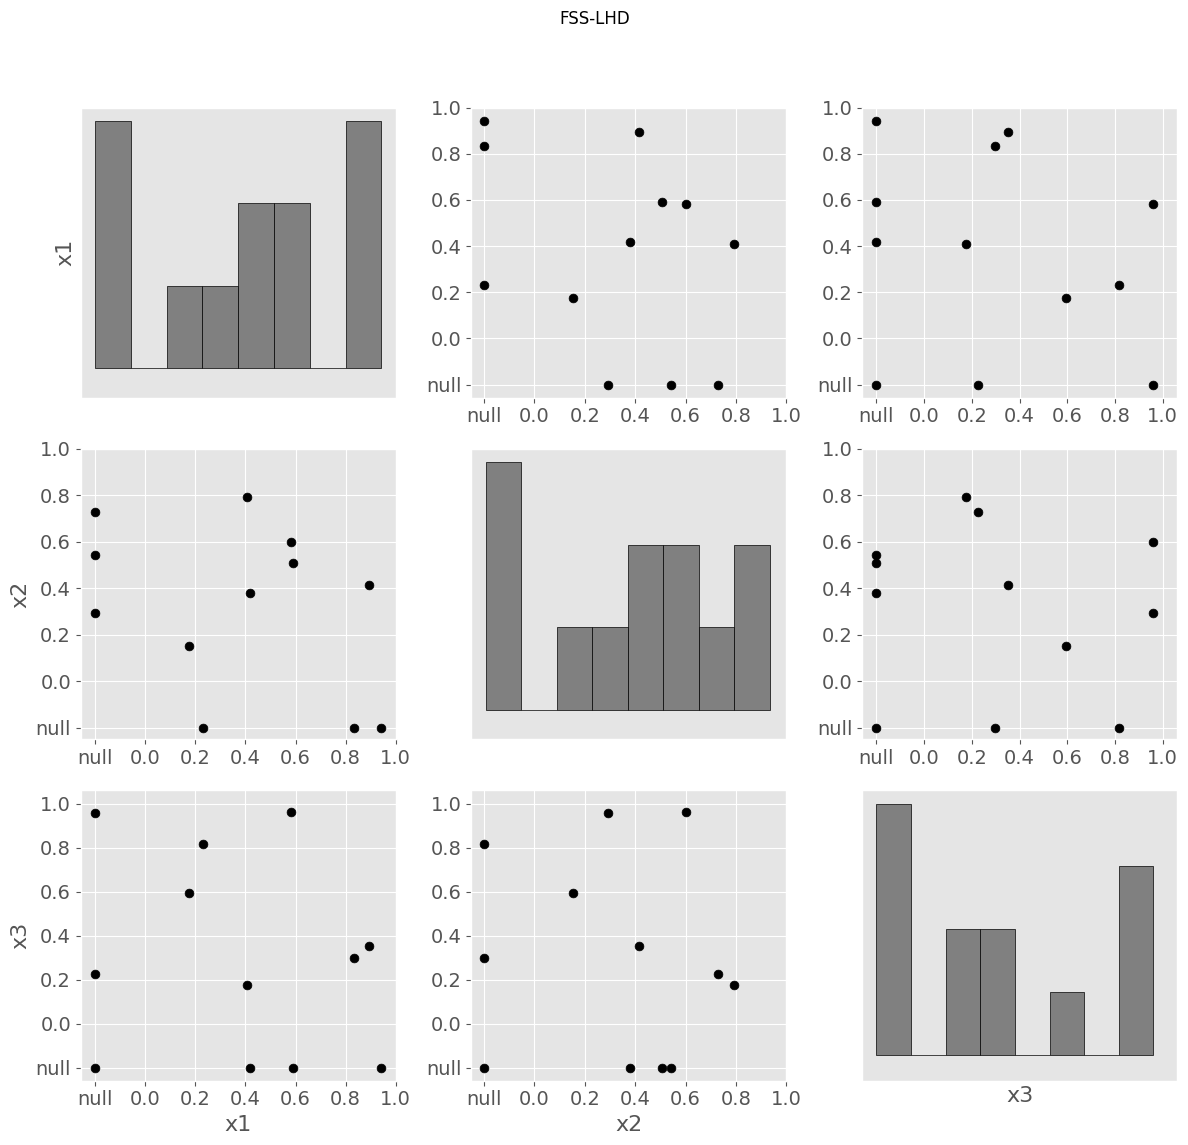

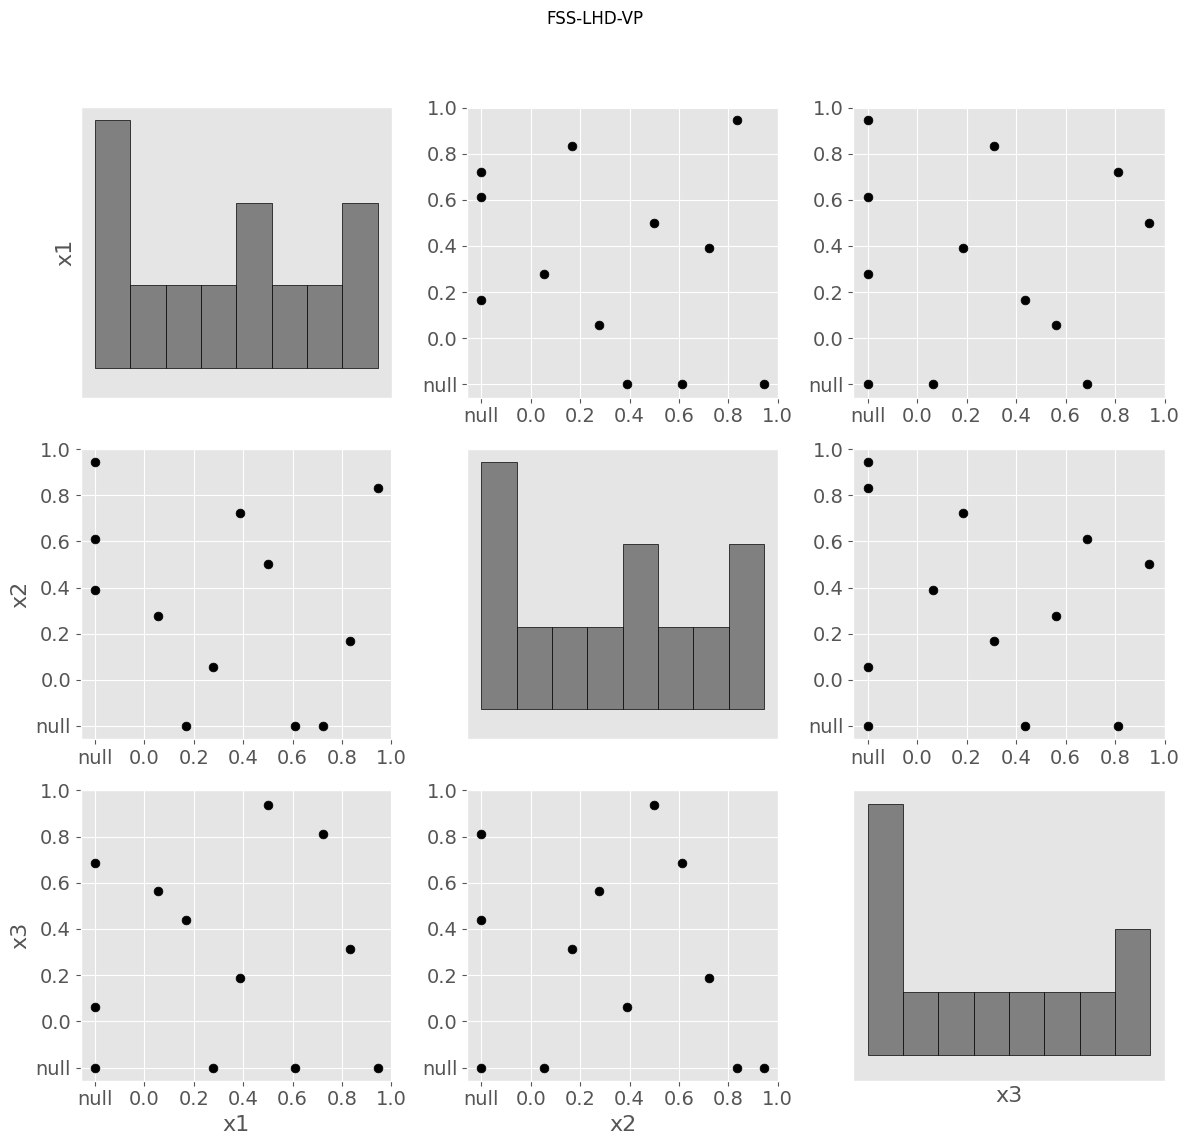

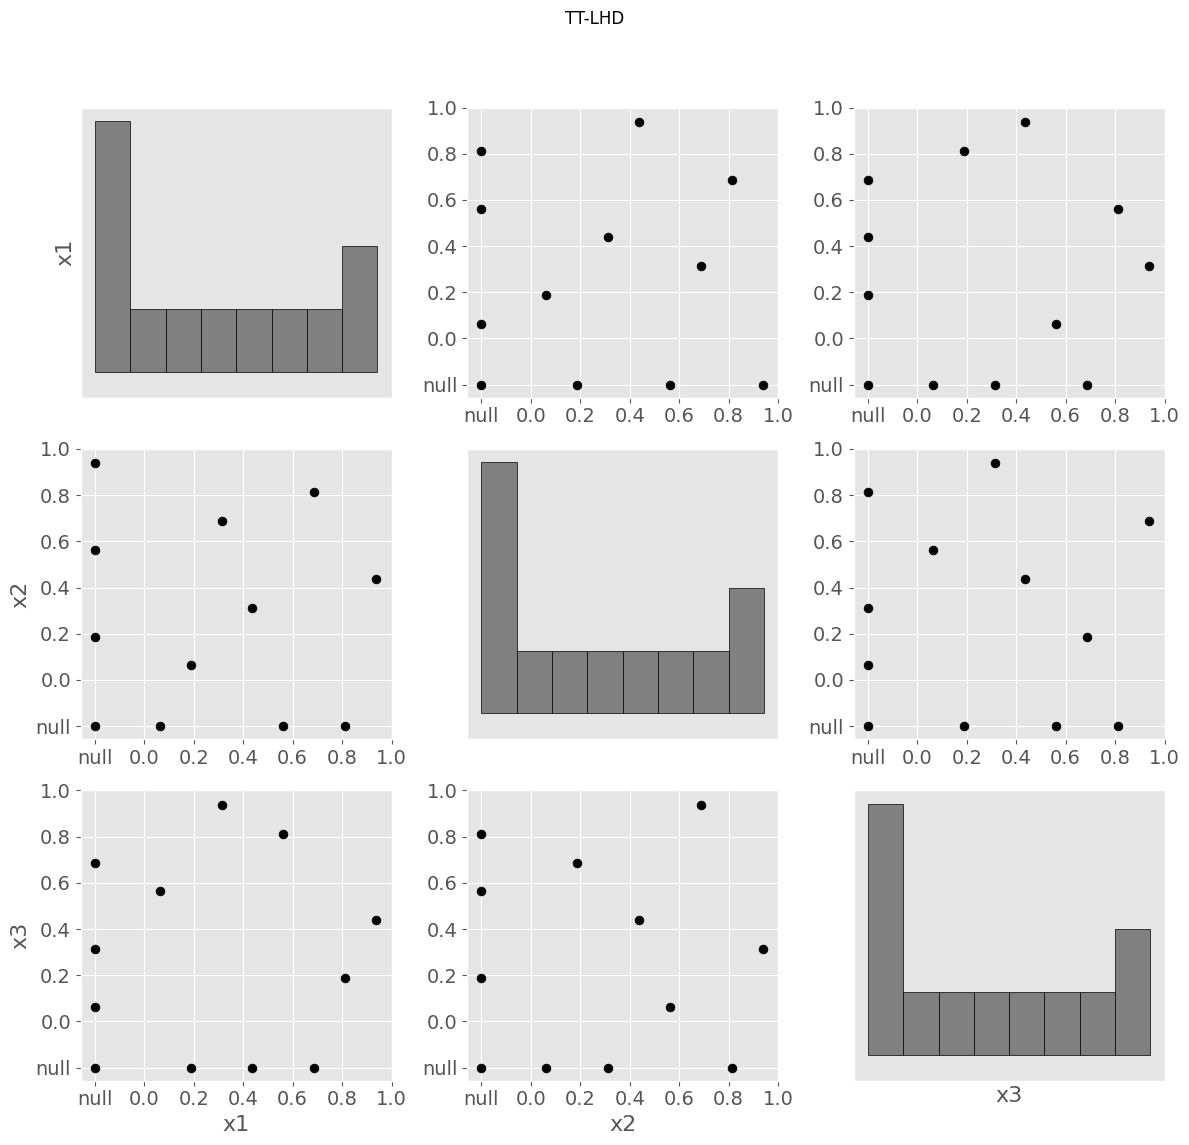

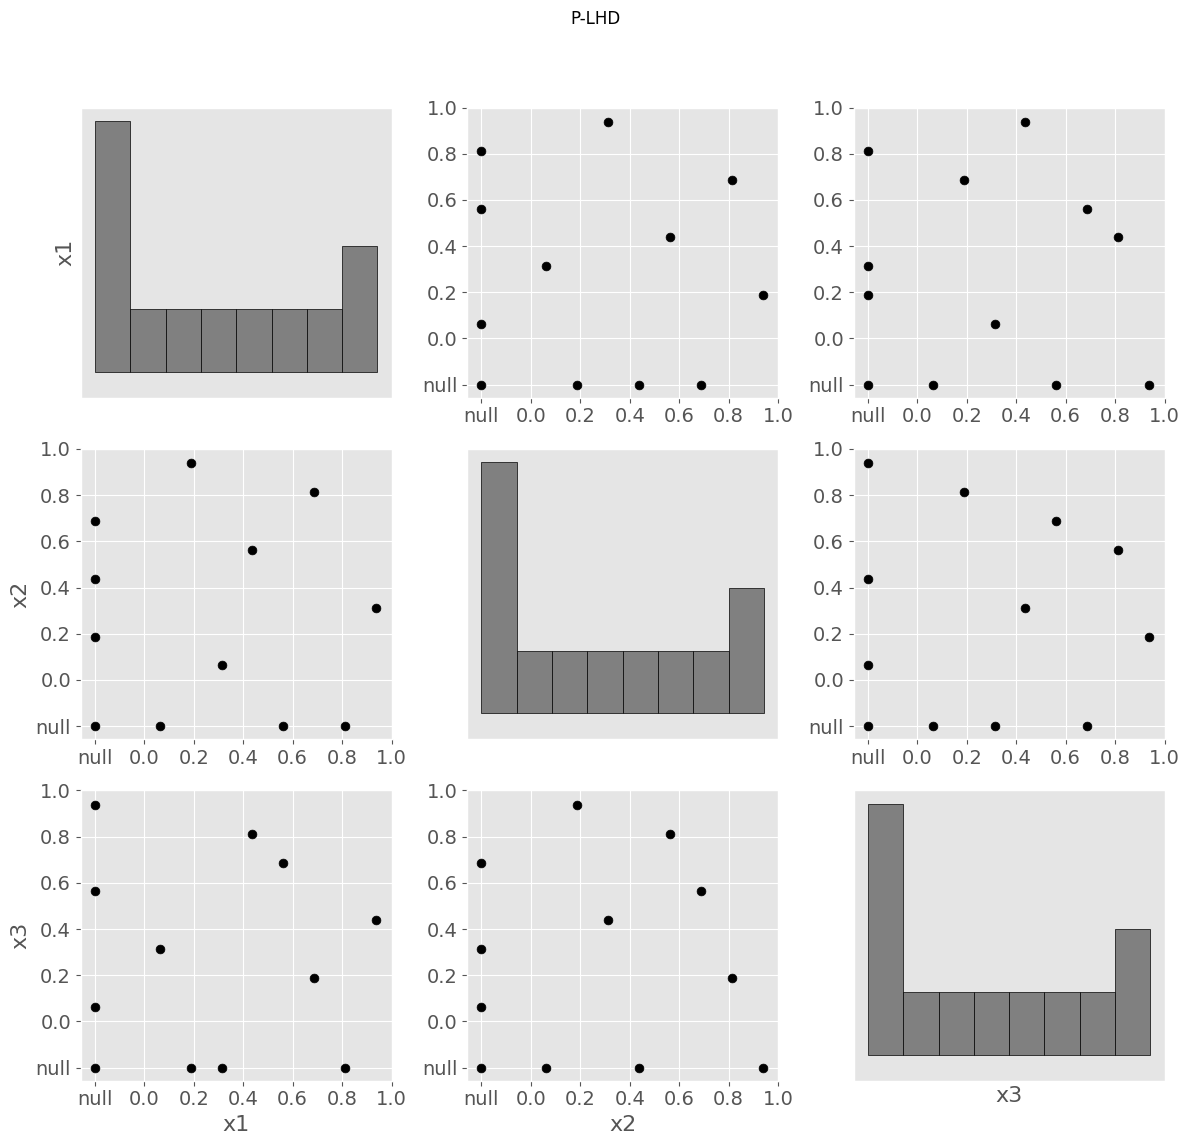

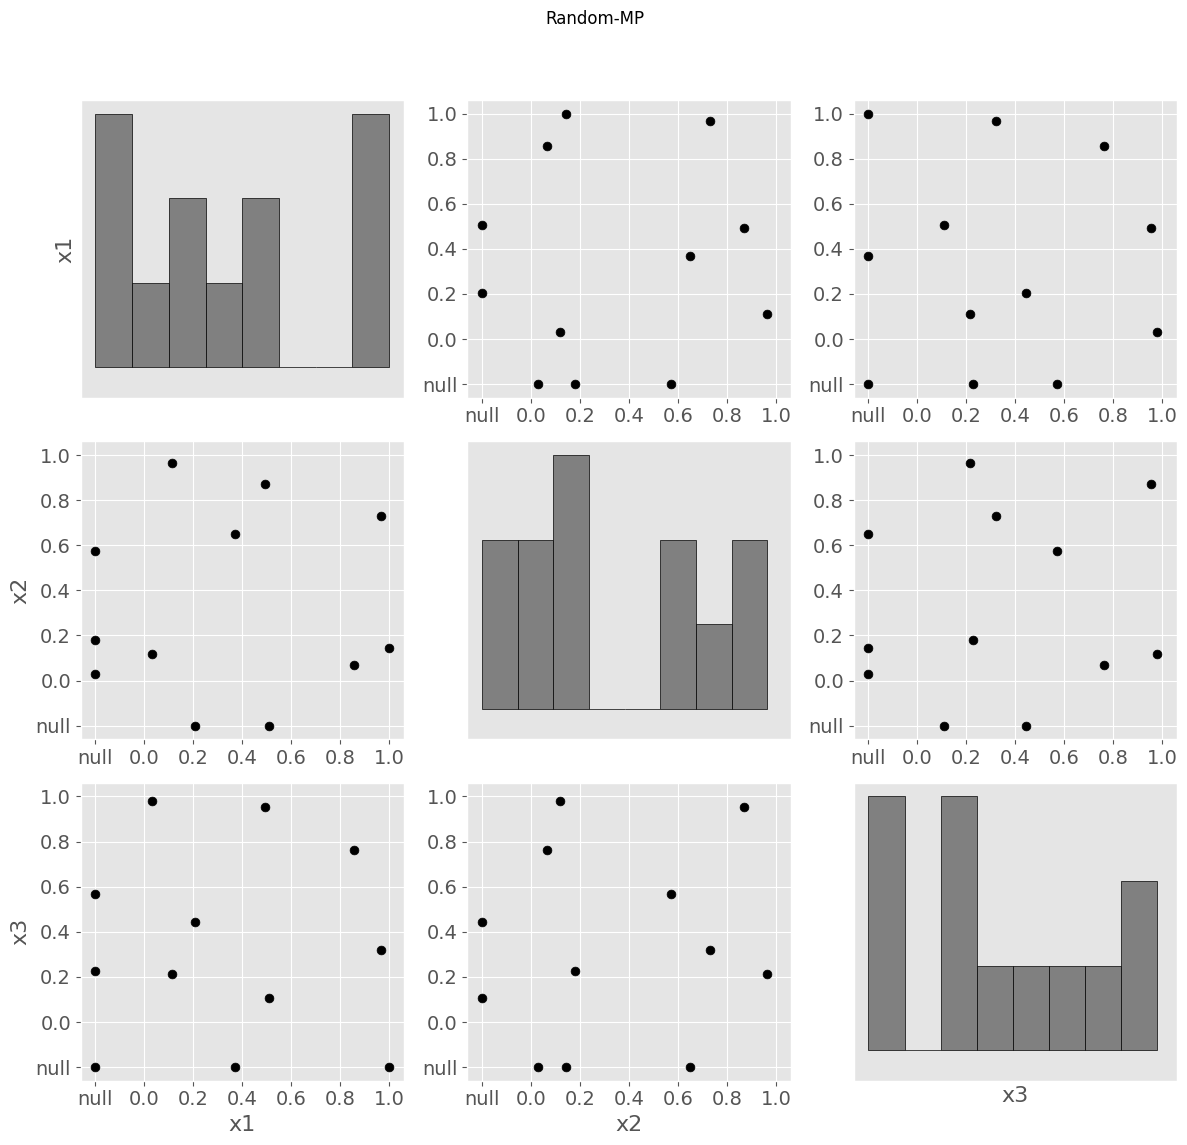

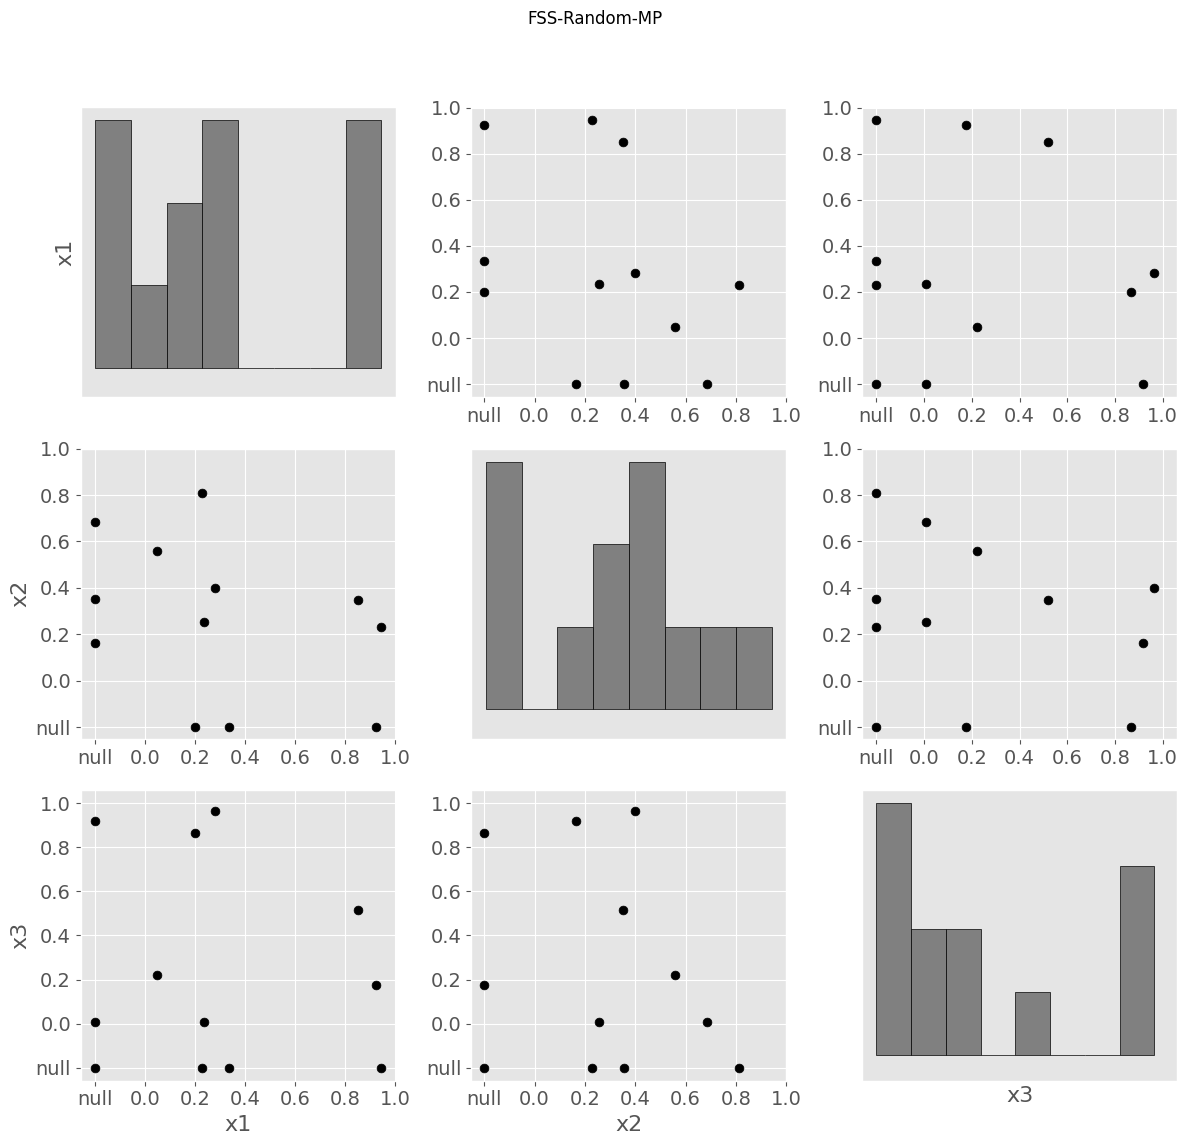

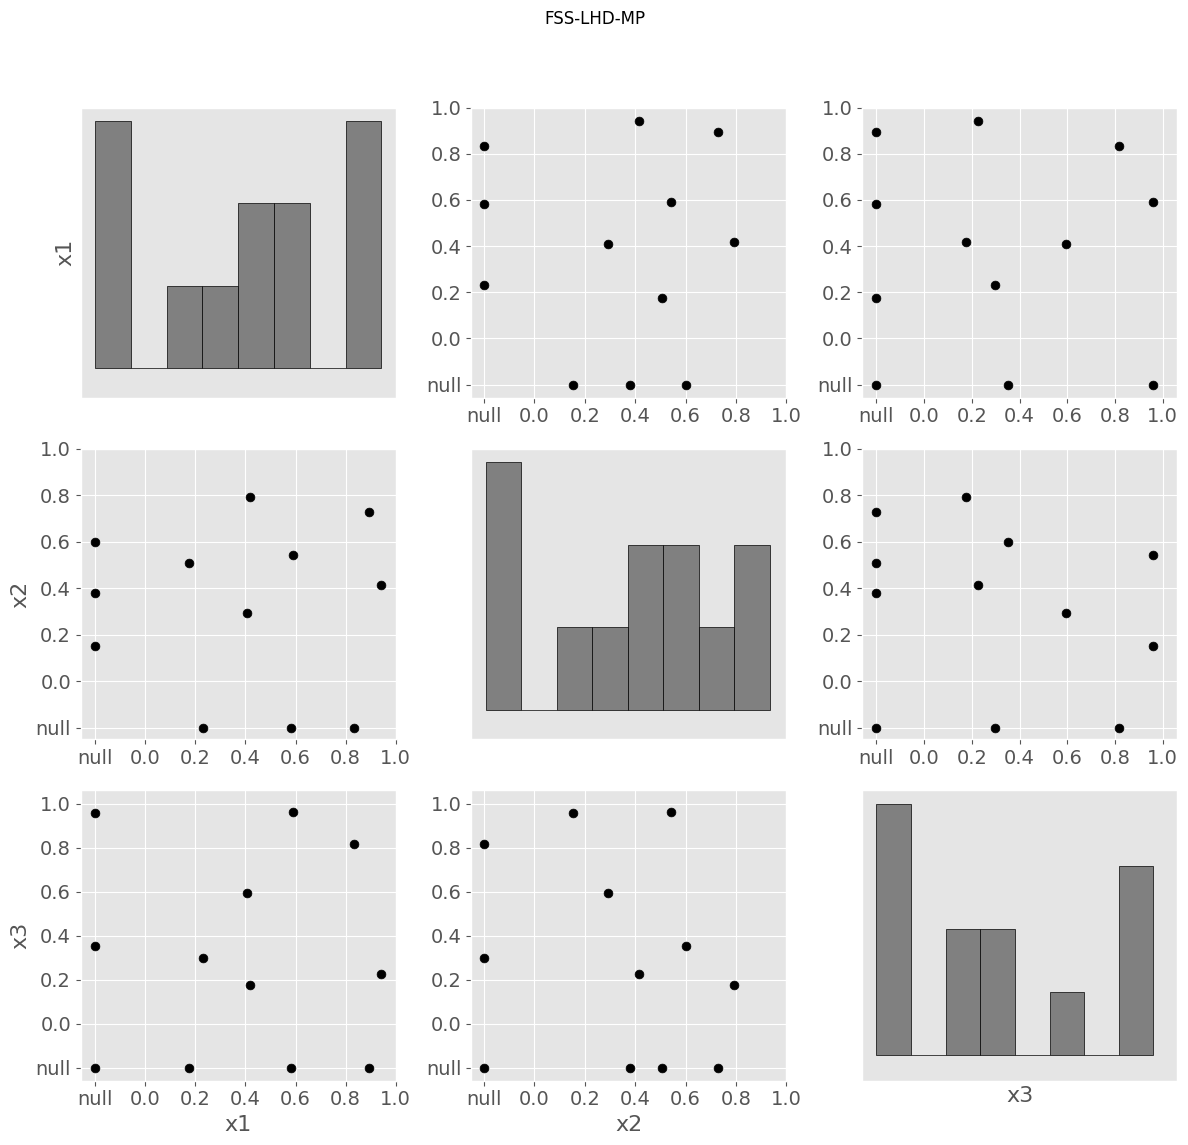

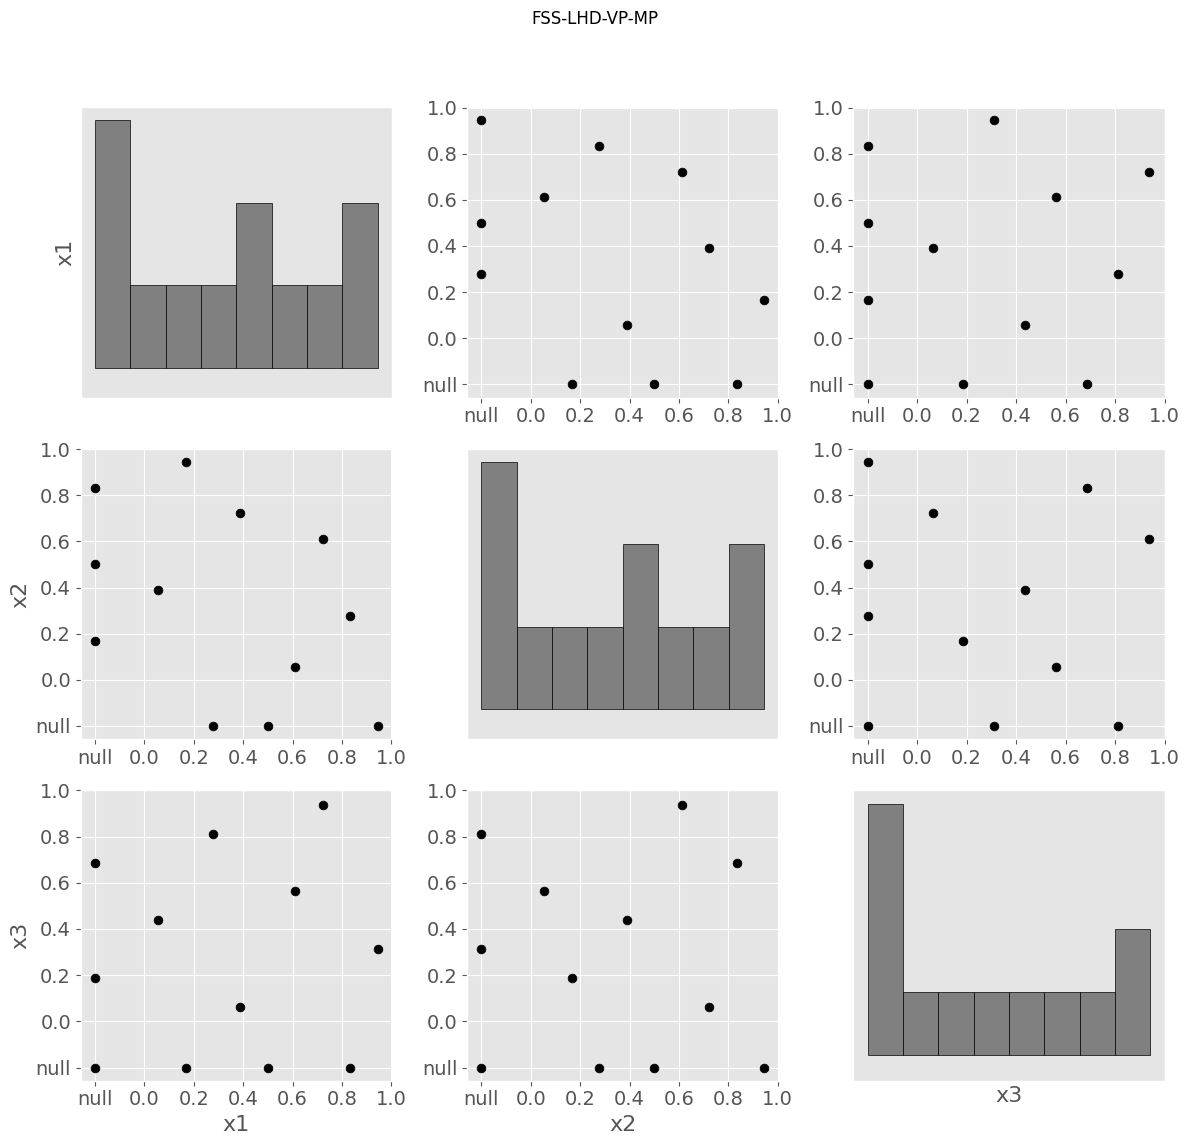

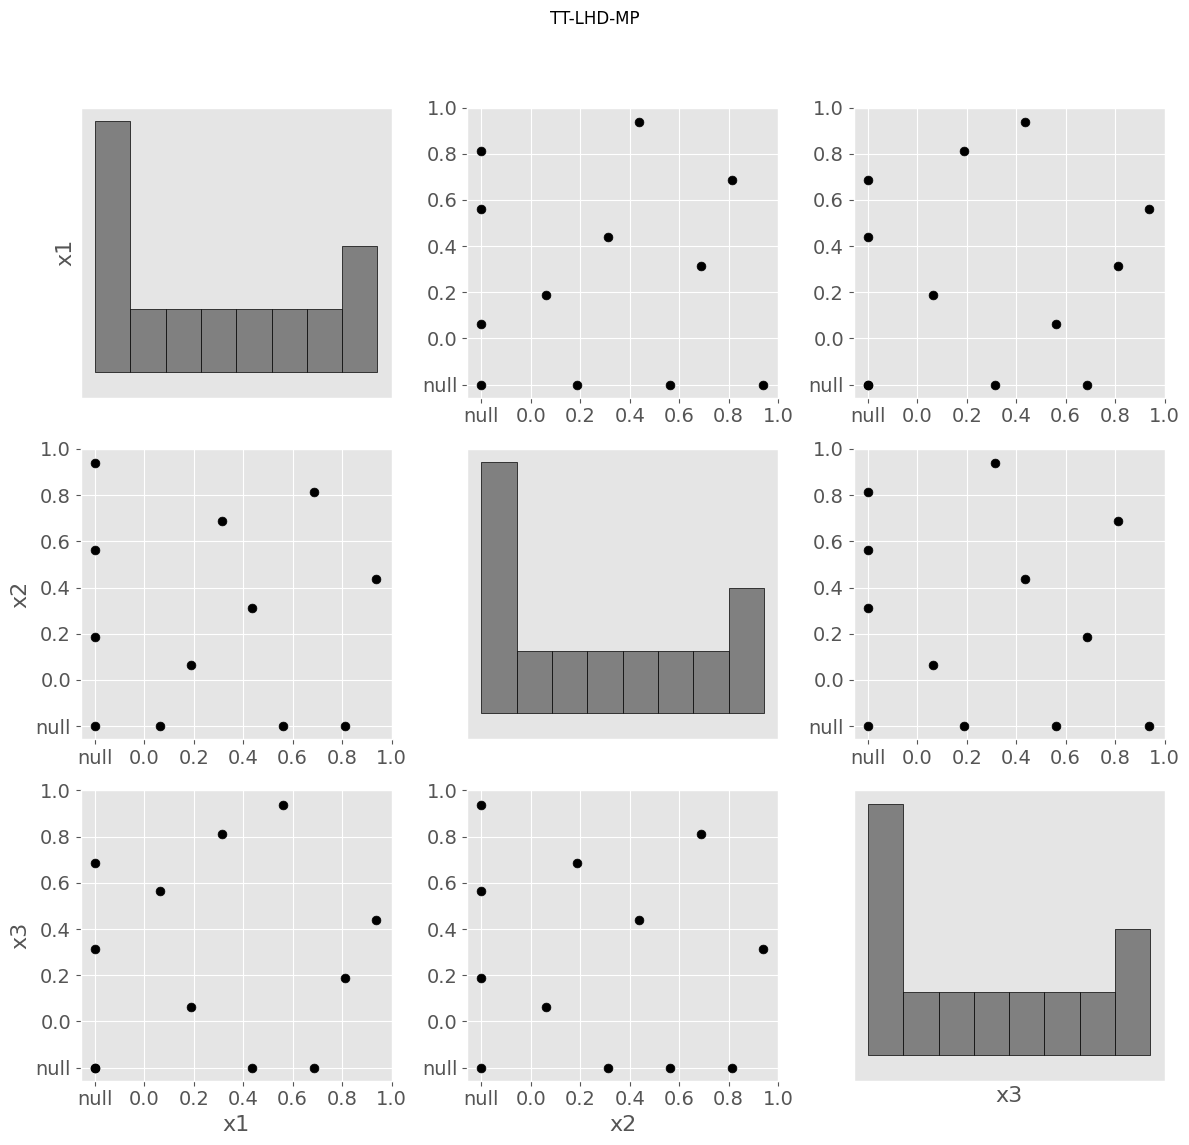

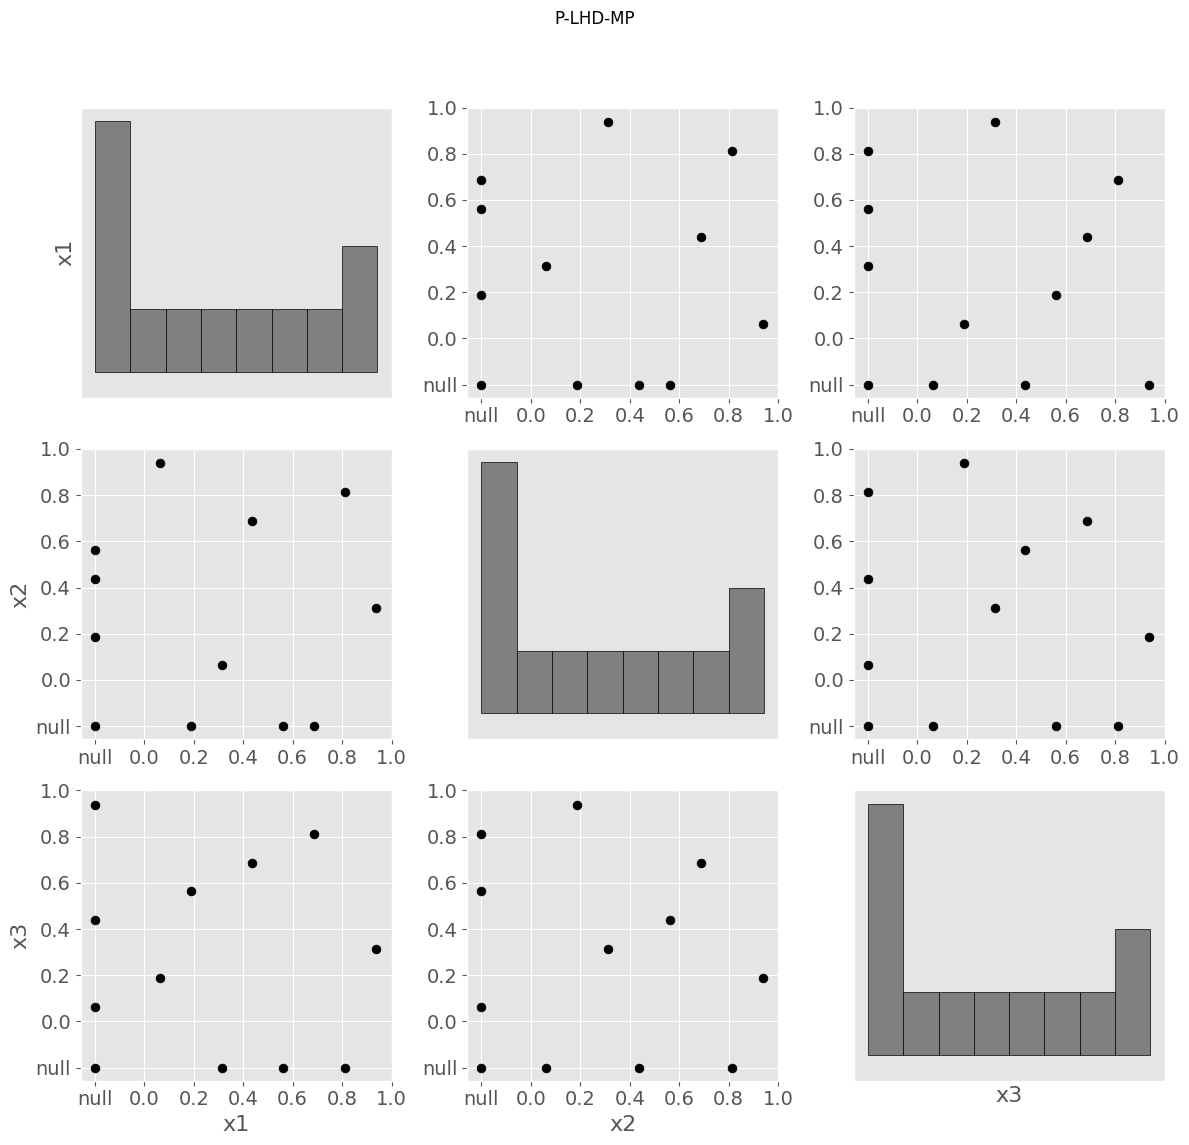

In [16]:
plot_designs(basic_assessment.problem_size_results[12], design_index =1)

In [17]:
assessment_group = split_designs_by_subspace_allocations(basic_assessment.problem_size_results[24], basic_assessment.input_space)
assessment_group.print_allocation_counts()
#assessment_group.generate_allocation_point_differences(target_sub_space_allocations)

(((), 0), (('x1',), 1), (('x1', 'x2'), 1), (('x1', 'x2', 'x3'), 15), (('x1', 'x3'), 1), (('x2',), 1), (('x2', 'x3'), 4), (('x3',), 1)) - 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
(((), 0), (('x1',), 2), (('x1', 'x2'), 4), (('x1', 'x2', 'x3'), 5), (('x1', 'x3'), 6), (('x2',), 1), (('x2', 'x3'), 5), (('x3',), 1)) - 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
(((), 1), (('x1',), 2), (('x1', 'x2'), 2), (('x1', 'x2', 'x3'), 8), (('x1', 'x3'), 4), (('x2',), 3), (('x2', 'x3'), 3), (('x3',), 1)) - 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0
(((), 0), (('x1',), 0), (('x1', 'x2'), 4), (('x1', 'x2', 'x3'), 10), (('x1', 'x3'), 5), (('x2',), 1), (('x2', 'x3'), 2), (('x3',), 2)) - 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
(((), 0), (('x1',), 1), (('x1', 'x2'), 3), (('x1', 'x2', 'x3'), 4), (('x1', 'x3'), 7), (('x2',), 2), (('x2', 'x3'), 3), (('x3',), 4)) - 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
(((), 0), (('x1',), 1), (('x1', 'x2'), 5), (('x1', 'x2', 'x3'), 7), (('x1', 'x3'), 7), (('x2',), 1), (('x2', 'x3'), 2), (('x3',), 1)) - 1, 0, 0

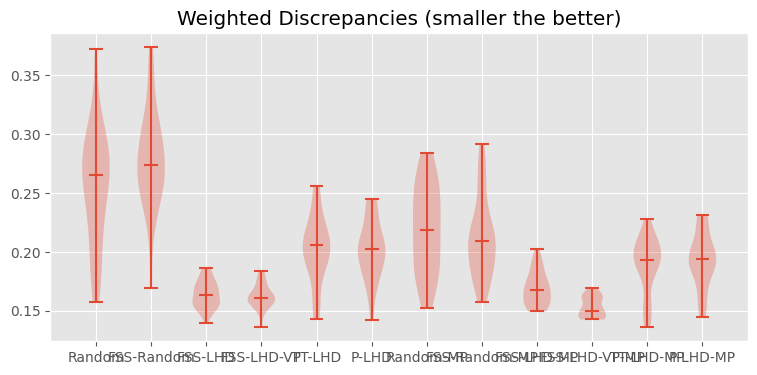

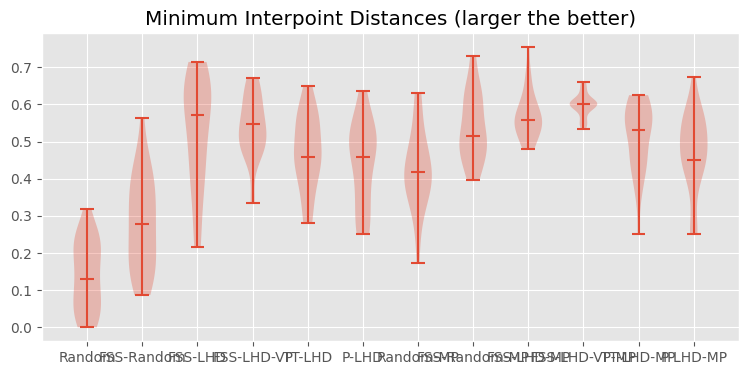

[[0.0004877700210194069, 0.013385660409619415, 0.006171295785206754, 0.006945393633684183, 0.0012796089069569416, 0.0010167541543577574, 0.0011800556919616123, 0.0038800283427552484, 0.01117888435801595, 0.002124574900384424, 0.001988343206857035, 0.004765122490813067, 0.007427941378453984, 0.025334112024571753, 0.003690488174517337, 0.0028445556695455565, 0.00024265475520046653, 0.0008360887271933737, 0.005830812755713066, 0.0006475234910356953, 0.0010687539392029155, 0.004499397578448694, 0.0003454567338946335, 0.028397810965560155, 0.0007194981700804348, 0.006014634274603137, 2.66531295317618e-06, 0.006596237189827492, 0.001015526275051526, 0.01752729533388936], [0.005684854827696761, 0.0008108848360752763, 0.0044917144616127835, 0.0009439228252818843, 0.002656323777422198, 0.0030649561992207586, 0.005331278777583104, 0.0028631465563296876, 0.0010378739635935608, 0.03854809571925166, 0.0012123075360774838, 0.004555021635401335, 0.00047464124943097374, 0.0043735893614296195, 0.001010

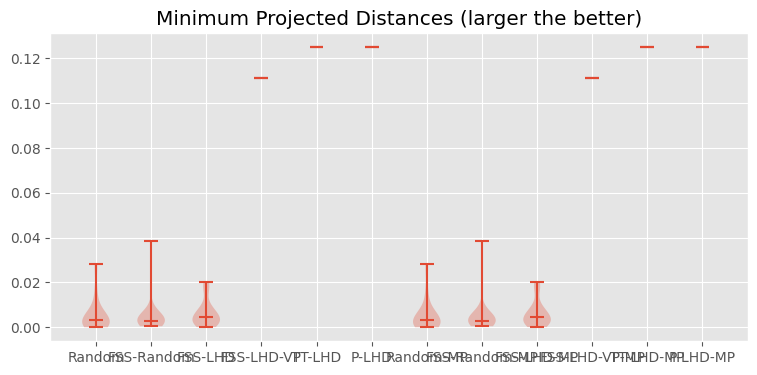

[[0.006422938924810773, 0.017930502904780595, 0.028453877751841734, 0.014367460291172973, 0.004057034271327771, 0.009991903868558083, 0.018301784295420842, 0.005477697367043621, 0.015271283938165492, 0.011092924390076234, 0.02081822010078327, 0.01726760753782175, 0.013484727243780747, 0.03742080333901635, 0.010294337112481788, 0.008371744094967548, 0.014754273492748604, 0.006414312203229393, 0.011124687664939606, 0.009635652213338139, 0.019852695521088187, 0.01371440420409592, 0.004571896411972698, 0.03843591378216432, 0.00165806846604305, 0.008215930470809868, 0.0051887529553028, 0.007509964817374146, 0.005171342626853814, 0.026780647568925287], [0.009554049611606774, 0.003947451520026994, 0.02140984299700192, 0.009759337110838798, 0.019166030649654275, 0.007153493387283549, 0.012076101718195212, 0.007686549220313347, 0.011993889453660422, 0.04220237495691581, 0.009714871401417061, 0.01706360882542668, 0.006930950678146308, 0.0086868417050134, 0.01206777356993923, 0.003376932780863077

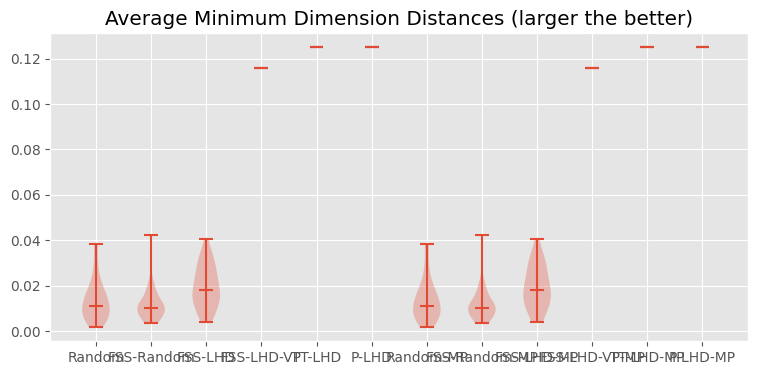

In [18]:
generate_basic_plots(basic_assessment.problem_size_results[12])

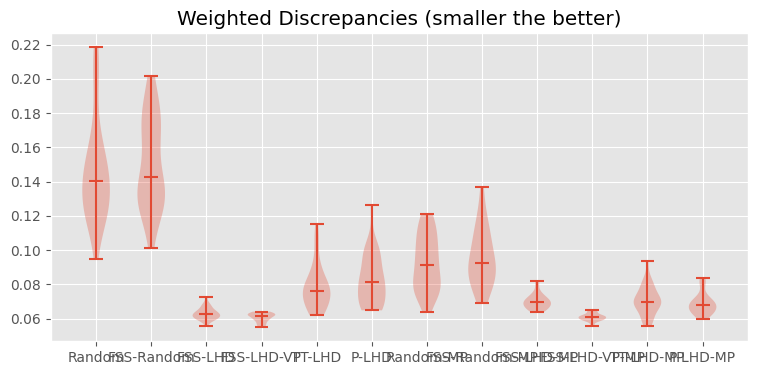

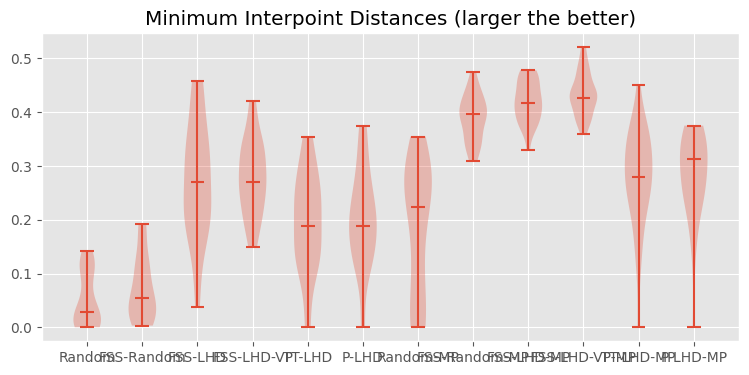

[[0.0010637935645144703, 0.00010324355814755881, 0.0009164048302178207, 0.0010017897457021974, 0.0016928654460227621, 0.0022264849179581825, 0.0020768850576602382, 3.622037865202987e-05, 0.005210028509428977, 0.0010034939810383836, 0.0030702290436087076, 0.0015362453141551935, 0.0021527191049021677, 0.0017636048170437402, 0.00028839151891557613, 0.0006645978052263746, 0.0015494670452411707, 0.002616334482068494, 0.0027661997878328792, 6.930364152590851e-05, 0.00029333137112486085, 4.7445681896629566e-05, 0.0007825871405947038, 0.001134809184548835, 0.004209235433545455, 0.00023003365399054676, 0.0002071705842803251, 0.0002922573708469822, 0.0026944779492803494, 0.0009574906558061924], [0.0011331474053820623, 0.0001470906891744006, 0.0006887070503123205, 0.0015256836174781796, 0.003916296982928058, 0.0005808033343013275, 0.0029704694232776108, 0.00036348903887906125, 2.6952392719881146e-06, 0.00035625034262665167, 0.0022260782018320713, 0.0034108337128151422, 0.0015506822619327787, 0.00

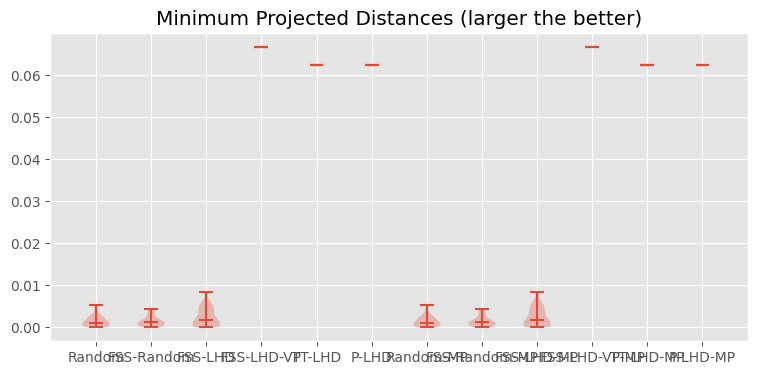

[[0.003273842160449847, 0.0048388367524475435, 0.002790419751206863, 0.0036193912922840576, 0.002729497273189737, 0.003628064152014998, 0.002212828038622938, 0.0034340461633705632, 0.009371749520542316, 0.003442303369925237, 0.005325199792774626, 0.0025436361718606526, 0.003633802345568852, 0.005925801383332319, 0.0038455660400837366, 0.0009979582750825888, 0.006435323317699193, 0.0031826096797060166, 0.006767738711891735, 0.005813047326371112, 0.004439641480336598, 0.003999386336884421, 0.002470550026672421, 0.002613766994075173, 0.006625548092776712, 0.004964836375119556, 0.0020869880703022203, 0.004670218194797071, 0.0031365245804569897, 0.007703250926466121], [0.00263530831872553, 0.004503954136244197, 0.002453126599805048, 0.0028477663505823703, 0.007369420180412349, 0.004587825424798668, 0.004848712971260623, 0.004436817174395887, 0.0031977939448441703, 0.001027811114254799, 0.004565373161709574, 0.006566839610085307, 0.008072096547026378, 0.006767017844388194, 0.0008776362856648

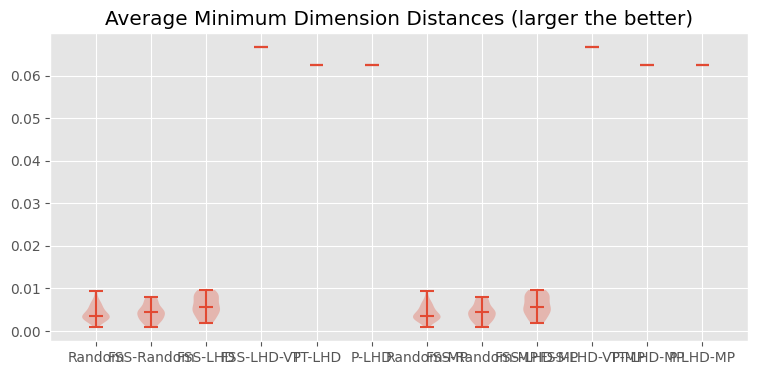

In [19]:
generate_basic_plots(basic_assessment.problem_size_results[24])

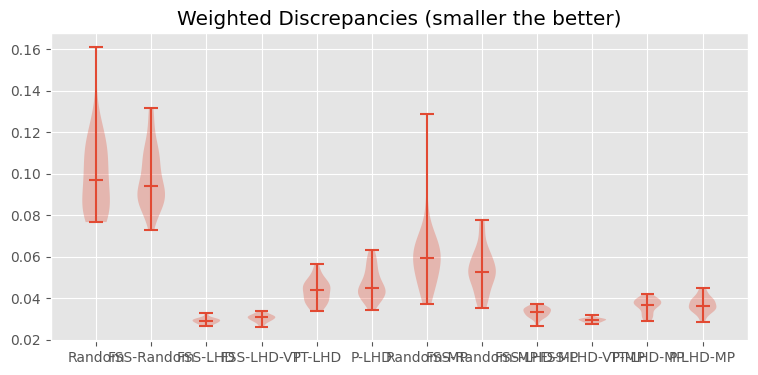

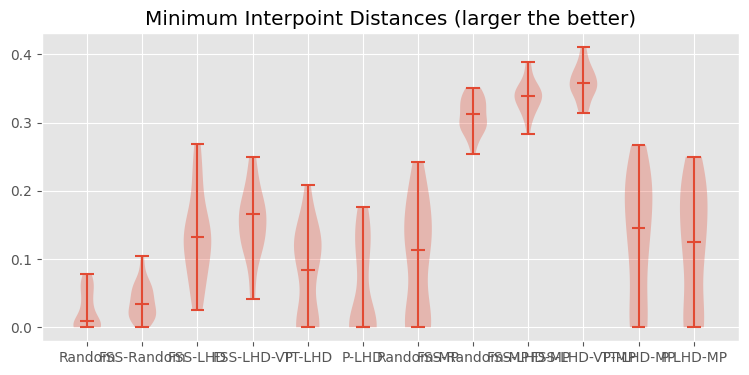

[[0.0003082108591009325, 0.0007109491438153648, 0.0031833619476922537, 0.00027649990276079617, 0.0006994734649173884, 0.0007304620191302402, 9.18342705347186e-05, 7.720220740226047e-05, 0.0003400684541262633, 0.0001313864919700869, 0.0014962887134670755, 0.00030137625648640753, 0.0005340061270345808, 0.0009525253217314567, 0.0004168651047238847, 0.0019125350698394605, 0.00029981781378096706, 7.547325086232348e-06, 0.00035898653142080184, 0.00015452737416721263, 0.000685885273671083, 6.958435600390445e-06, 0.00012646091087509248, 0.00011147036725034365, 5.9206059491723195e-06, 0.0010223248086401182, 0.00023467714449920685, 0.00044774518369111727, 1.577370951688639e-05, 0.0006744976344452702], [0.0009074459262735646, 0.000595691961823297, 0.004220015711588365, 0.0001189913396926201, 0.0035199392945156616, 6.423037735792114e-05, 0.0015142561557508483, 0.0004303630200352959, 0.0002462717425212313, 0.0011748598486907014, 0.00021249100739140214, 0.0004225969264256557, 1.794851957392929e-05, 

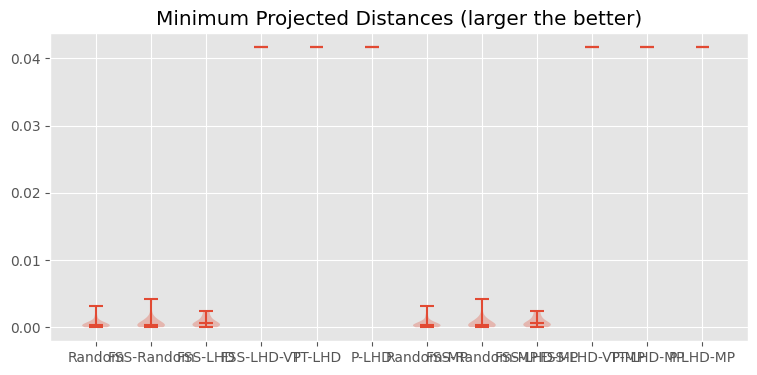

[[0.0013814782020446503, 0.0013764025709598338, 0.004204067231819819, 0.002010046050953118, 0.00110857536185525, 0.0031296752268625268, 0.001051352031596194, 0.0004981834121130513, 0.000901770468557217, 0.0018698628864050049, 0.0021948641939221747, 0.002032811068108653, 0.001854228468977685, 0.0015876600021250686, 0.0016994757555907625, 0.0021218095602910845, 0.002150271332429713, 0.0004388409354299701, 0.0009788358995030388, 0.0027705316652439915, 0.0009485715551128723, 0.0007071352726139013, 0.0005450213931042502, 0.001124732384266025, 0.002365913191131793, 0.001713288092974219, 0.004162737041888076, 0.0012117566049990591, 0.001573422590817201, 0.0011896427622762884], [0.0016729552716653329, 0.0012373664991716105, 0.005078300630350492, 0.00038217970669407464, 0.004794405673755479, 0.0020084330835593947, 0.003237705453748944, 0.0011000731963034527, 0.0023782023419723166, 0.0013945719094115756, 0.0006919203793018062, 0.001148726296918497, 0.0004073154736119096, 0.0018145259909588818, 0

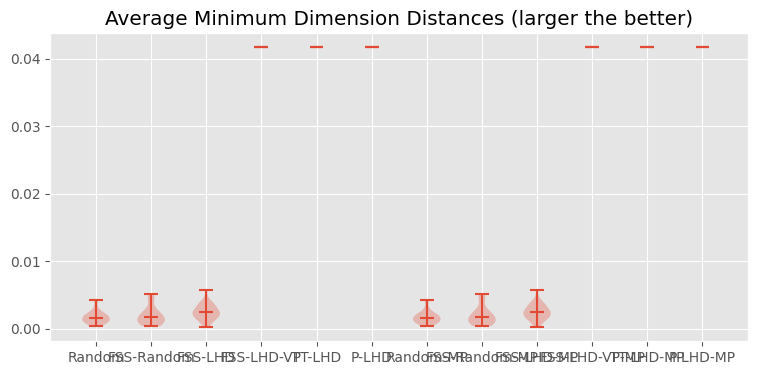

In [20]:
generate_basic_plots(basic_assessment.problem_size_results[36])

In [19]:
# custom assessment plots
# plot_sub_space_assessments(strategies, ("x1","x2","x3"), measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ("x1","x2"), measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ["x2","x3"], measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ["x1","x3"], measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ["x1"], measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ["x2"], measure.METRIC_DISCREPANCY)
# plot_sub_space_assessments(strategies, ["x3"], measure.METRIC_DISCREPANCY)

# Assessment B: Simple Heirarchy

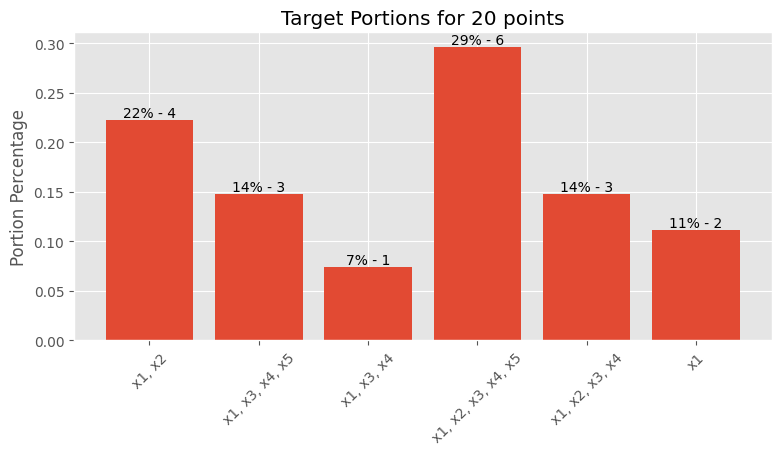

In [21]:
assessment_simple_heirarchy = AssessmentSet.Initalize(
    assessment_name="simple_heirarchy",
    strategies=strategies,
    input_space=s.InputSpace(
        dimensions=[
            s.Float(id="x1", lb=0.0, ub=1.0, nullable=False, portion_null=0.0),
            s.Float(id="x2", lb=0.0, ub=1.0, nullable=True, portion_null=(1/3)),
            s.Composite(id="x3", nullable=True, children=[
                s.Float(id="x4", lb=0.0, ub=1.0, nullable=False, portion_null=0.0),
                s.Float(id="x5", lb=0.0, ub=1.0, nullable=True, portion_null=(1/3)),
            ], portion_null=(1/3))
        ]
    ),
    # target_full_sub_space_portions_bh={
    #     ("x1","x2","x3"):17,
    #     ("x1","x2","x4","x4_1","x4_2"):14,
    #     ("x1","x2","x4","x4_1"):5,
    #     ("x1","x2","x3","x4","x4_1","x4_2"):45,
    #     ("x1","x2","x3","x4","x4_1"):14,
    #     ("x1","x2"):5
    # }
)

number_of_points = 20
plot_fullsubspace_target_portions(assessment_simple_heirarchy.input_space, number_of_points)



In [22]:
assessment_simple_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(20,),
)

At least some results exist for 20.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [23]:
assessment_simple_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(40,),
)

At least some results exist for 40.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [24]:
assessment_simple_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(60,),
)

At least some results exist for 60.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


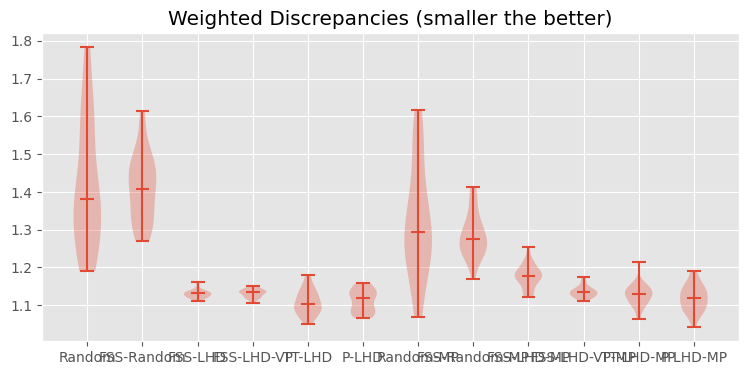

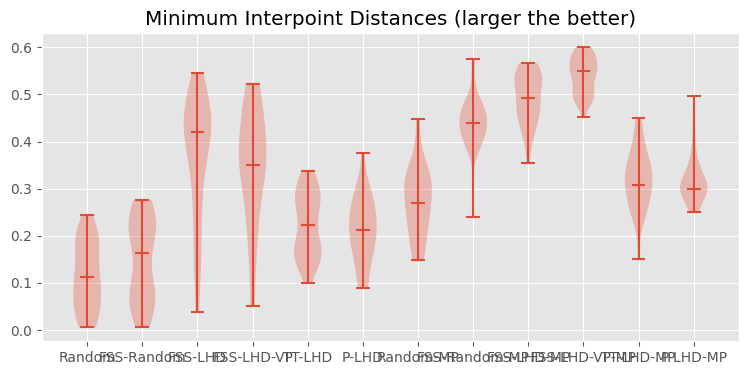

[[0.0005358008177106521, 0.0004944121314648386, 0.0016915272980402296, 0.0005829680616005195, 0.00120811273505661, 0.00025335663806669295, 0.003823347410439326, 0.0004418602292834972, 0.0015324741849701562, 0.00047846343091662025, 0.000246896681517228, 0.0005342403451151778, 0.0007327129153680279, 0.0003238910872216394, 0.0003472885554168803, 0.00026965688224644957, 0.0007219914319650522, 0.00019837576207437646, 0.0007947541591908358, 0.00236635656088946, 0.0007653958964886076, 0.0008025326206043681, 0.0005663101607692456, 0.00047670916237863015, 0.0003345939934454867, 0.000365854639979013, 0.0008216301525693082, 0.0009580879000852249, 0.0007441136232867462, 0.0031642960121051056], [0.002065158964180469, 0.002266541585934756, 0.00025843896942123745, 0.0033246246230762555, 0.0006845241574005012, 0.00016536250447696244, 0.0007725807431292475, 0.0018568057355144996, 0.0024834049073118036, 0.0005787393287431941, 0.0013155832350806307, 8.370616778063944e-05, 4.0662071409069966e-05, 0.001366

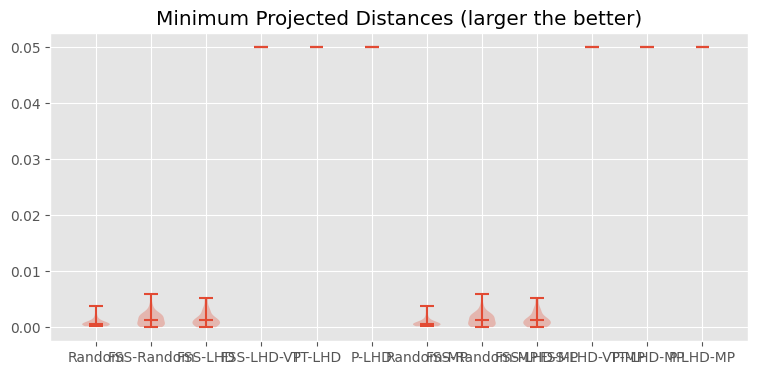

[[0.0019214029107698094, 0.009426424126669431, 0.009142380191766853, 0.002157907923928959, 0.004073672760932001, 0.005265414158459469, 0.005845339542816852, 0.007936858863800777, 0.004143710014866908, 0.002396301449250271, 0.007062193235443659, 0.0032684764429915638, 0.002791496886582201, 0.00216866656745901, 0.007659509816141341, 0.0032160359372283677, 0.004731475759311321, 0.012060404437513583, 0.001798173742944309, 0.00313596260126896, 0.008465343781859614, 0.006252849849293996, 0.0027420347811276226, 0.0009306806096627928, 0.002150028436962914, 0.0025087007679983953, 0.0010400453868944948, 0.012114683765889468, 0.007293894941033829, 0.006034394254647135], [0.004265043155191472, 0.0050980292350678805, 0.001558200654075903, 0.004677850622669522, 0.00680945777597306, 0.0045257981376981785, 0.0012837507311426633, 0.007238809344119157, 0.007426316912006214, 0.0017820875184417551, 0.004583409268004934, 0.004470717561820381, 0.0034787502345608123, 0.006846141758183988, 0.00296866203251506

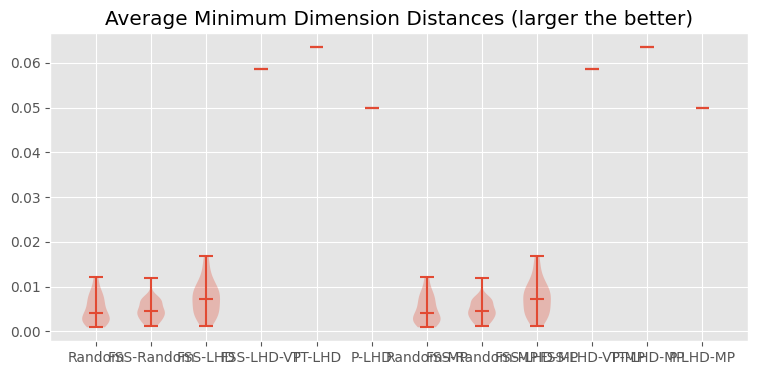

In [25]:
generate_basic_plots(assessment_simple_heirarchy.problem_size_results[20])

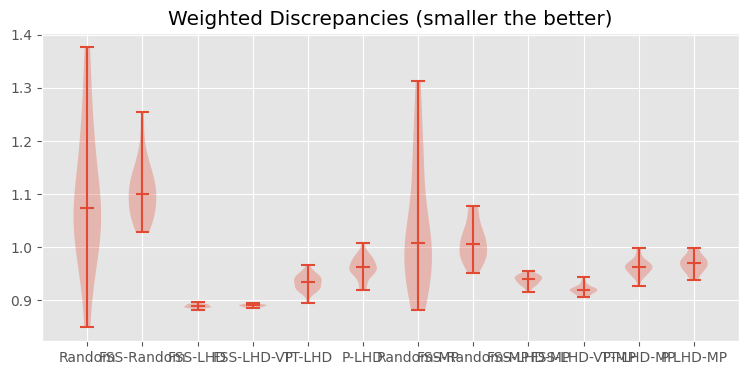

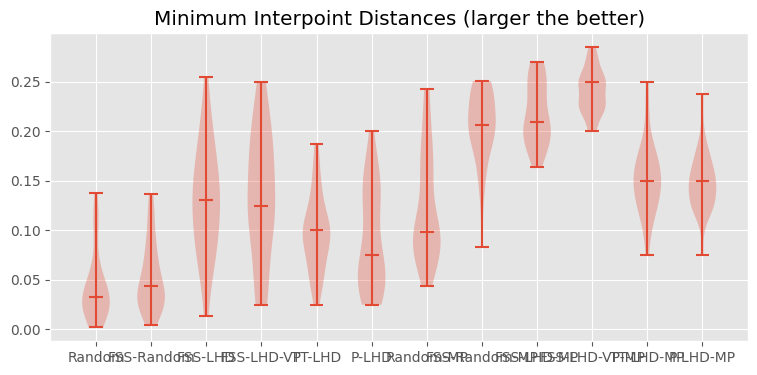

[[1.934934890412965e-05, 0.00016883879530371626, 0.0003641146982683585, 0.00021731349746501039, 0.00039275152855255957, 0.00020453784769181027, 0.00024199730694740573, 6.20704074478784e-05, 6.173448950641536e-05, 3.105648927492766e-05, 0.0004936843536843538, 0.00021818671867046557, 0.0004006517327592718, 0.00010924674066992157, 8.197045376800993e-05, 0.00017623563253665875, 0.00010651654790683196, 4.4978989756749854e-05, 0.00010228178397009291, 0.0003608820239666688, 0.000667767258159313, 0.0003698150608510975, 0.00022817564416155456, 1.4322349048967453e-05, 0.00040976931532421546, 0.0001539472338905612, 0.00044310124911722815, 0.0022087974309976666, 5.8497963941417375e-05, 0.0004242213835715658], [0.00021428181248905886, 0.00045562379848318457, 0.0003037486155114122, 0.0002315592799368993, 0.00019705972389605364, 0.00027533192421469455, 4.748302145696215e-05, 4.239726407795352e-05, 0.0001609652046343779, 3.249745455735642e-05, 6.304563680126218e-05, 7.656905678554704e-05, 0.0005917516

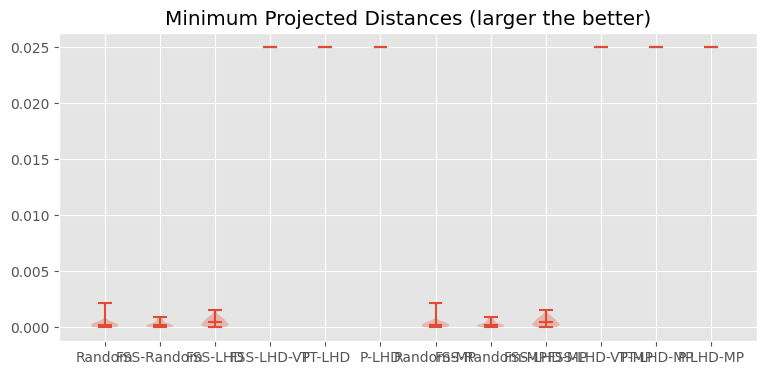

[[0.0007267982475746782, 0.0016402025602558295, 0.003115192591310856, 0.0023321122463519474, 0.0008713521785539635, 0.0013659375434987187, 0.0006618806543772337, 0.0010043973080426482, 0.0007940357302971823, 0.0009488806213654554, 0.0023912442167306814, 0.0007081617257092221, 0.0013230945491761626, 0.0013446754012204076, 0.0011040983347125667, 0.0007960051116092437, 0.0013194381020300238, 0.00028520865628973714, 0.0004031415560366014, 0.0017362979724118044, 0.0014326260373583644, 0.001780434630786165, 0.0013551258354221219, 0.001810308221157597, 0.0018969837567686554, 0.00038780068535637646, 0.0010973353931658437, 0.003329681849139543, 0.0002882249316644381, 0.0026579789253359356], [0.0025373322752086703, 0.0005666098420263222, 0.0029508249553967802, 0.00040001833797314034, 0.0013711754752221417, 0.0007921175051705864, 0.0006463302820990613, 0.001254267817240562, 0.001324517882170917, 0.0007072004478600125, 0.0002963079152835224, 0.0010291385019961963, 0.0021226354106967937, 0.00047098

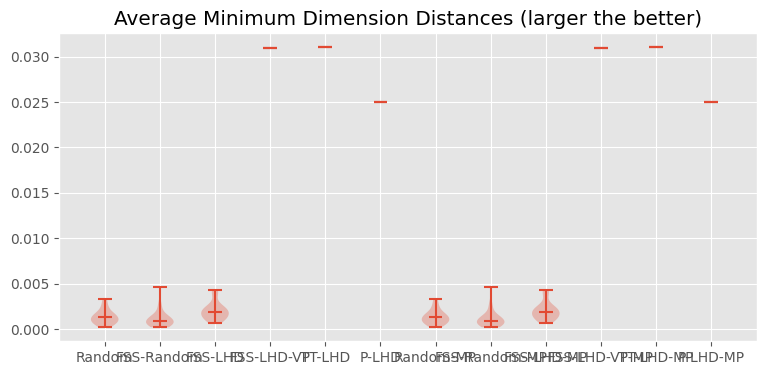

In [26]:
generate_basic_plots(assessment_simple_heirarchy.problem_size_results[40])

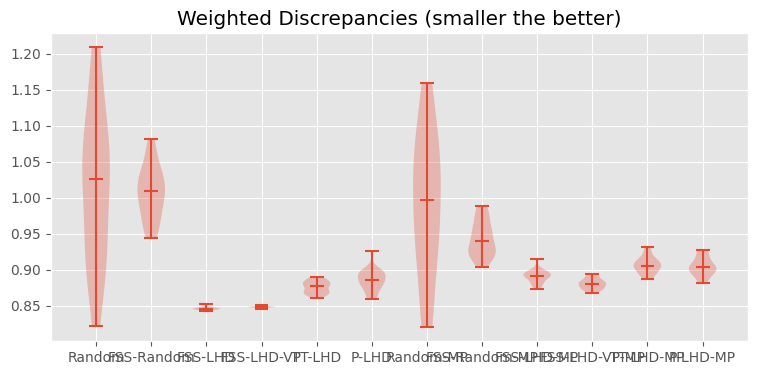

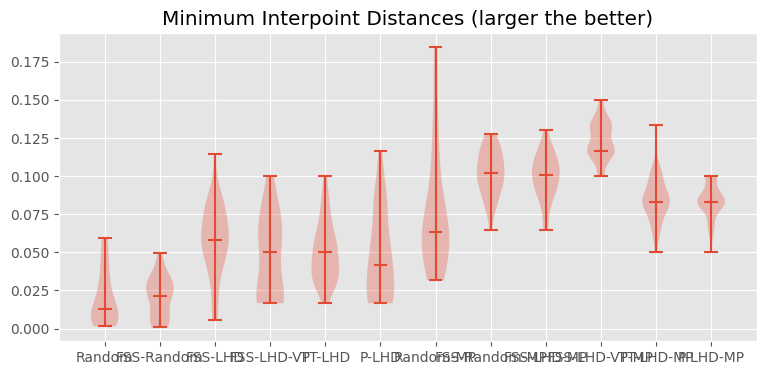

[[2.583631789621066e-07, 0.0002683653194772706, 0.00010580808581917012, 1.1273471920869582e-05, 0.0001919074043041924, 1.799047060990766e-05, 0.0001861992457453665, 2.1561860195640214e-05, 0.00011164187421647265, 0.0002309540584687353, 0.00011085390459031341, 3.803138751723445e-05, 1.9278167198932827e-05, 2.5357297792294453e-05, 0.00021685300844365152, 0.00015495933217468671, 0.00021030256848786344, 0.00041709569169057215, 0.00010163627725778834, 0.0002547450030178089, 8.368682009674e-05, 3.6087677669494056e-06, 0.00011211268486854831, 2.328078433411207e-05, 4.92497123237845e-05, 1.3673145203174641e-05, 0.0001871737187594258, 7.638558176326082e-05, 0.00012970017683455737, 0.0003687831674002995], [0.0004152423386480919, 0.0001692635205545745, 0.0005574014034267494, 0.00017210480053031496, 4.777648986087346e-05, 1.71653066303179e-05, 1.572076890554719e-05, 0.0005026814850080941, 0.00028720475965604564, 0.00011607717727690758, 5.411015666689778e-05, 0.00024500966449669814, 6.4757439713902

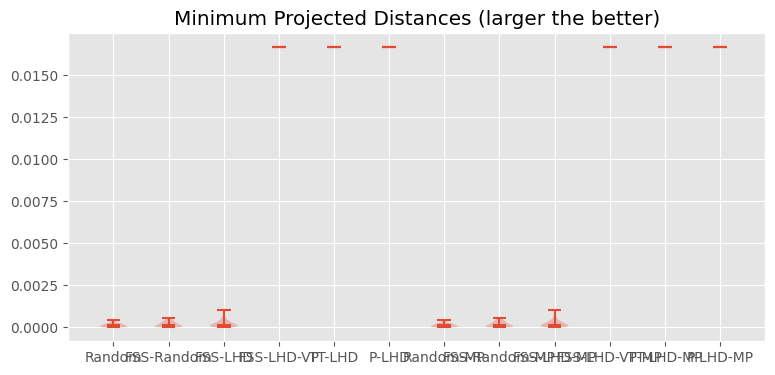

[[0.00011419431172992045, 0.0008284963787422717, 0.0006025180222984372, 0.00025179399587884623, 0.0009412400170345614, 0.00025619264847692724, 0.00038233741633866283, 0.0006049649960538916, 0.0004647655324407585, 0.0005828911706486472, 0.001732945631626248, 0.0004297223388975091, 0.0005335350965772534, 0.0015411139345204992, 0.0017547721451318444, 0.0003442169540551321, 0.0004833783189105878, 0.0004930907311803234, 0.0013933450850143081, 0.0006132849893338621, 0.0006722457438274043, 0.0002437441294874443, 0.0005381582190223777, 9.974215986761071e-05, 0.0006808426791711564, 0.0013630500054841676, 0.0016070428464937559, 0.00042183776805928554, 0.0004032638934891253, 0.0006747967776696284], [0.00056960551495151, 0.000459587355640223, 0.00073356748157698, 0.0003748031008183217, 0.0005011462430120517, 0.000704884851662424, 0.0005561060904593518, 0.0009177079314763636, 0.0005008236275269029, 0.00031634202028576477, 0.00048695208181990244, 0.0006401655145377827, 0.0003090214635464994, 0.00066

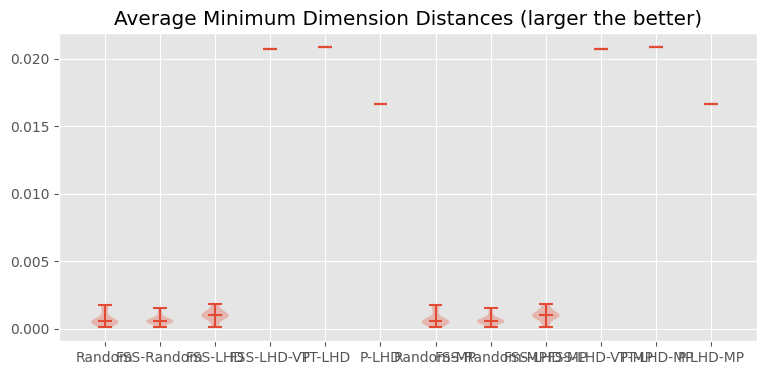

In [27]:
generate_basic_plots(assessment_simple_heirarchy.problem_size_results[60])

# Assessment C: More complex hierarchy

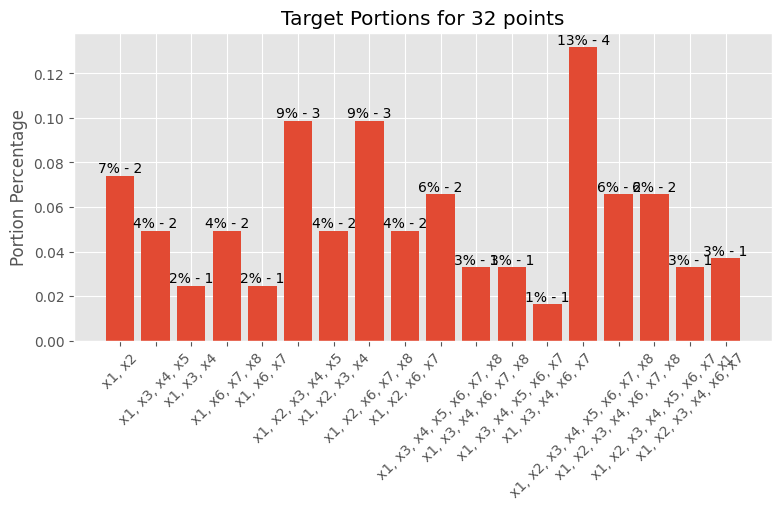

In [28]:
assessment_modest_heirarchy = AssessmentSet.Initalize(
    assessment_name="modest_heirarchy",
    strategies=strategies,
    input_space = s.InputSpace(
        dimensions=[
            s.Float(id="x1", lb=0.0, ub=1.0, portion_null=0.0),
            s.Float(
                id="x2",
                lb=0.0,
                ub=1.0,
                nullable=True,
                portion_null=1.0 / 3.0,
            ),
            s.Composite(
                id="x3",
                nullable=True,
                portion_null=1.0 / 3.0,
                children=[
                    s.Float(
                        id="x4",
                        lb=0.0,
                        ub=1.0,
                        portion_null=0.0,
                    ),
                    s.Float(
                        id="x5",
                        lb=0.0,
                        ub=1.0,
                        nullable=True,
                        portion_null=1.0 / 3.0,
                    ),
                ],
            ),
            s.Composite(
                id="x6",
                nullable=True,
                portion_null=1.0 / 3.0,
                children=[
                    s.Float(
                        id="x7",
                        lb=0.0,
                        ub=1.0,
                        portion_null=0.0,
                    ),
                    s.Float(
                        id="x8",
                        lb=0.0,
                        ub=1.0,
                        nullable=True,
                        portion_null=1.0 / 3.0,
                    ),
                ],
            ),
            # s.Variant(
            #     id="x6",
            #     nullable=True,
            #     portion_null=0.33,
            #     options=[
            #         s.Float(id="x7", lb=0.0, ub=1.0),
            #         s.Float(id="x8", lb=0.0, ub=1.0),
            #     ],
            # ),
        ]
    )
)


plot_fullsubspace_target_portions(assessment_modest_heirarchy.input_space, number_of_points=32)

In [29]:
assessment_modest_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(32,),
)

At least some results exist for 32.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [30]:
assessment_modest_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(64,),
)

At least some results exist for 64.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [31]:
assessment_modest_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(96,),
)

At least some results exist for 96.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


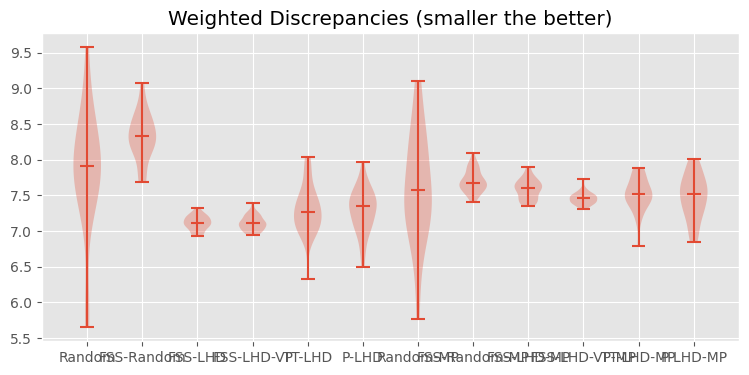

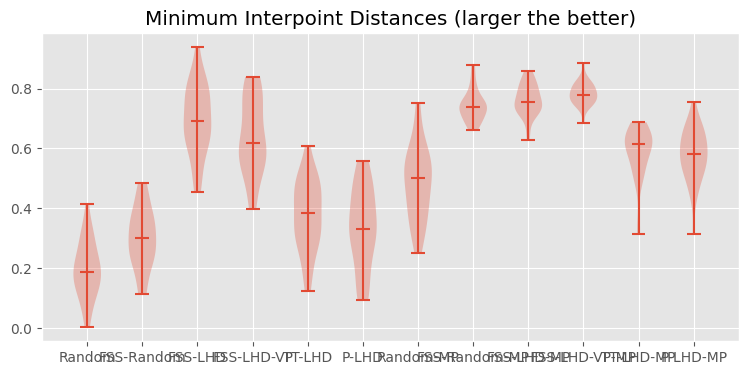

[[5.4185957760743975e-06, 0.00012740538283073644, 0.0003486143777480244, 0.00042095680727993745, 0.0001894244485288743, 0.00021893520508708963, 0.0007203102494921509, 1.4925728559767037e-05, 0.0006994536543484253, 3.011144170372848e-05, 7.685154263881167e-05, 0.0003124737381944853, 0.0004848331621836177, 0.0006949407257589302, 0.00046280508331031367, 0.0007107765650566922, 0.0005581129911187421, 3.355271377070146e-05, 0.00037360037832323556, 0.00018690663838272226, 0.00028224105247509623, 8.693391121028515e-05, 0.00023583377116465076, 0.00027017849590649234, 8.099535147443326e-05, 6.0396509372950824e-05, 0.00010560070921422637, 0.0006566390487560136, 0.00027795608973013586, 4.1133494538492243e-05], [0.00012971810715689536, 0.0003954876528581286, 1.839927021873855e-05, 0.00021193581175626974, 0.00029906793777378926, 0.0006595184995604741, 0.0002254127782181925, 3.937948920407219e-05, 0.00033184743663594585, 5.2217243830865456e-05, 0.00016096043123303705, 2.6688871019642235e-05, 9.816327

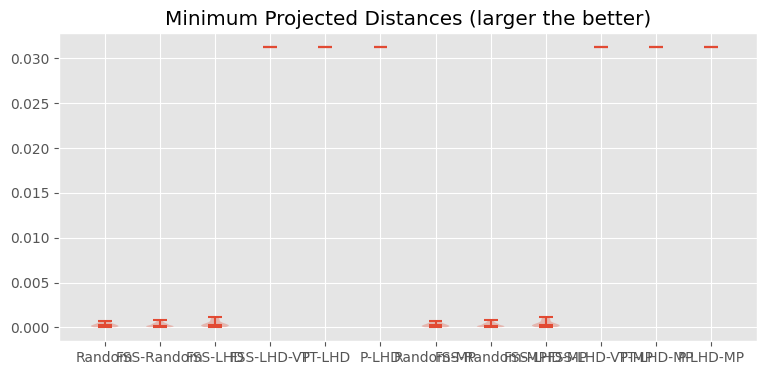

[[0.0031371323528294817, 0.005791651150718474, 0.0012958602524576618, 0.002279008701889601, 0.0026688687979056144, 0.0013839907859966444, 0.0027415939338846854, 0.002225250389949633, 0.002677343508740909, 0.001896829370989325, 0.004212503204633608, 0.0021959233107365986, 0.001479368888517782, 0.003173494683894801, 0.0025366671408092595, 0.0015032915766736224, 0.002063790044983929, 0.0023807375491321087, 0.001882865063219677, 0.0009017415062021056, 0.003371119389060373, 0.005013548252007324, 0.0031832091408400404, 0.0011326615228411316, 0.003721999758458355, 0.003076565363986851, 0.003725112477794161, 0.0031042337149554677, 0.0016523797848842434, 0.003857485095458038], [0.0013863462647656921, 0.0032887570363291235, 0.0014985699534574015, 0.0016535006435225014, 0.0026173985868929717, 0.00335199653553446, 0.0018946297105874171, 0.002115207915384429, 0.0034100685410200643, 0.0014536986774031369, 0.0010517761591253005, 0.005241241110692657, 0.0019297643149482069, 0.0014577739806960893, 0.00

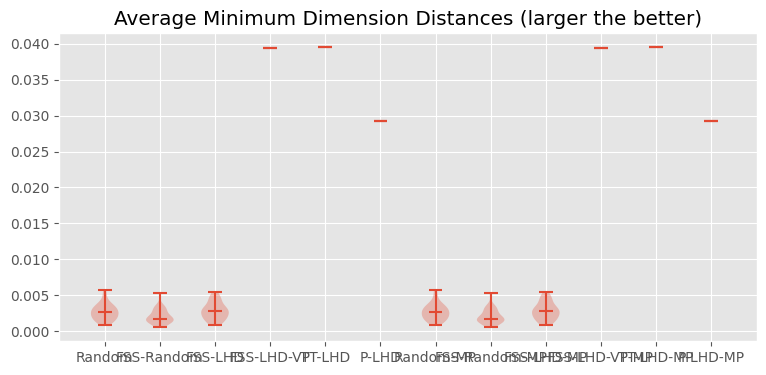

In [32]:
generate_basic_plots(assessment_modest_heirarchy.problem_size_results[32])

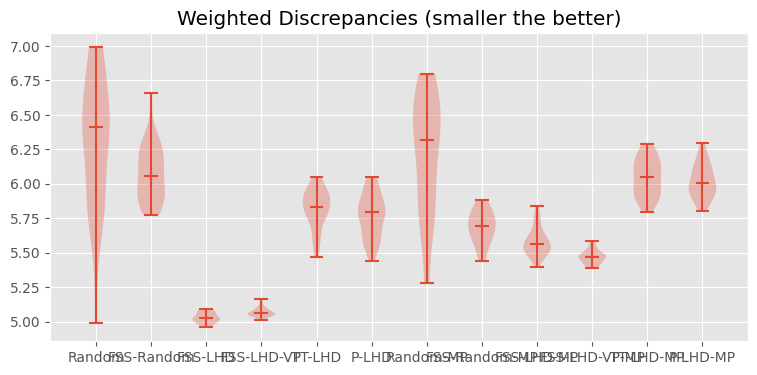

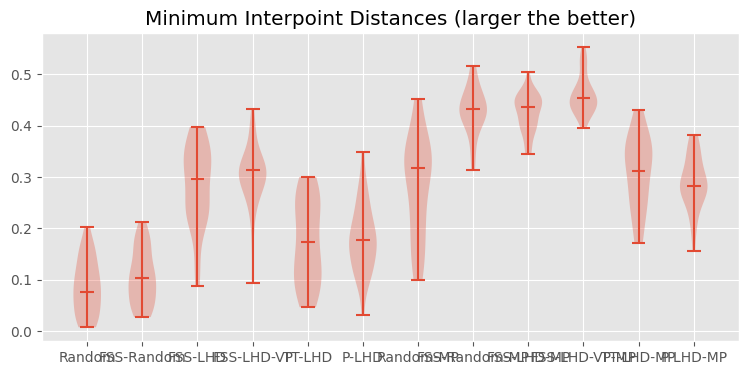

[[9.244806613056822e-05, 2.2924667231416507e-05, 5.859773236194243e-06, 0.0001309902975323296, 0.00017084954082363657, 1.3738409998520495e-05, 4.337033641110821e-07, 4.8297371236238895e-05, 0.00014336802069159216, 2.7918368932788873e-05, 2.9721534548665662e-05, 9.865359194660694e-05, 4.8889667724205665e-05, 1.5149105931588913e-05, 1.9998504795004646e-05, 0.00011743148115406221, 0.00029325771387389565, 0.000315404542238773, 7.116217439728789e-05, 0.00012384887376981624, 1.5931859671525217e-05, 4.46071953577043e-05, 0.00011389301301389931, 0.0002448999728963397, 4.873081203449203e-05, 0.00011030922080346173, 3.934990709519859e-05, 0.00022371768775297785, 8.292520870234465e-05, 1.9554002711030805e-05], [2.0272779286178988e-05, 0.00014602512803907342, 7.560982665577587e-05, 4.8439108748299375e-05, 1.355994822138662e-05, 6.082766230408598e-05, 3.5922748584438224e-05, 9.842058013331823e-05, 8.796014854606238e-05, 4.150815462455881e-05, 3.3848387025470217e-06, 8.762357429525913e-06, 1.8467044

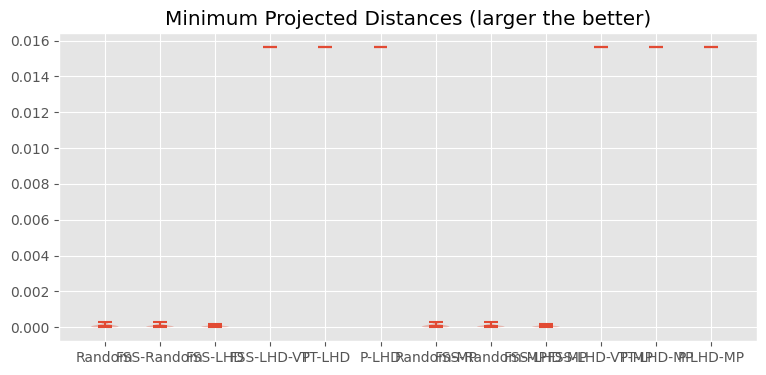

[[0.0007529064444718112, 0.000795560842431986, 0.001044299171117015, 0.0004477691175794052, 0.0007471899688827749, 0.0005621061408476319, 0.0005774998531365844, 0.0010835139365771018, 0.0007083729607634745, 0.00023717561105820323, 0.0002449168686617237, 0.00035462916291278956, 0.00024837561293029886, 0.00035856080919815375, 0.0002595119474821869, 0.0004914244653959551, 0.0005904724690747876, 0.0003484598521079005, 0.000664561300639889, 0.00033698626707968915, 0.0007536605272054075, 0.0005720994978376942, 0.00030181137956186016, 0.0010050810827296752, 0.0011514234162225828, 0.0008666613942009543, 0.00036313790827909725, 0.0005504599049067638, 0.0010775300063327053, 0.001200587113237471], [0.00044473079249844616, 0.0007411209634931304, 0.000533916464828102, 0.00066619805163394, 0.00047093713481233257, 0.000415407058633549, 0.0004840378142625529, 0.00034887203079728146, 0.0005163899080196238, 0.000374011411957309, 0.0003790525037460357, 0.00029680916451123307, 0.0003636715320214229, 0.000

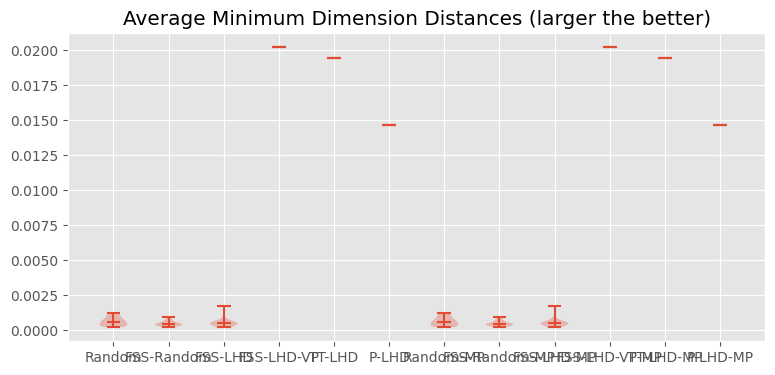

In [33]:
generate_basic_plots(assessment_modest_heirarchy.problem_size_results[64])

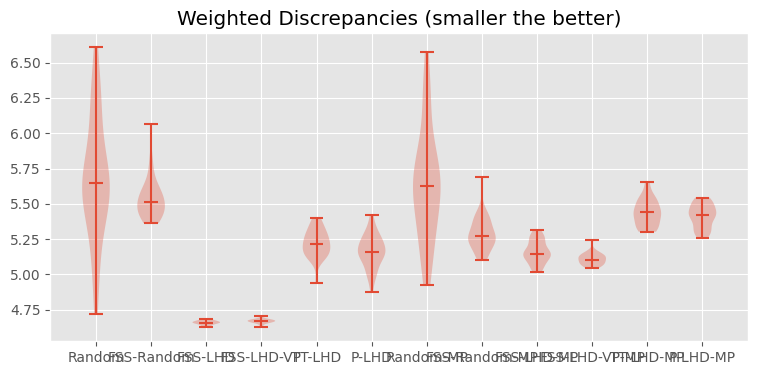

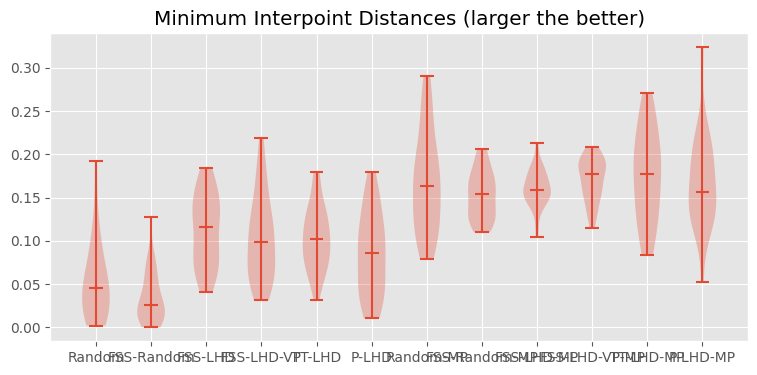

[[1.5115248728492237e-05, 0.00016086502180923112, 1.5509069475339032e-06, 7.44414040194652e-05, 7.7315576442194e-06, 1.225274871086146e-05, 8.304313473717073e-05, 1.35656257831962e-05, 6.033465718702224e-07, 9.575183382848351e-07, 2.1546357775070746e-05, 9.947380451791332e-06, 3.603608673496961e-05, 2.529666627537619e-05, 0.0001231178576396874, 9.530120402834186e-06, 3.768718239460789e-05, 2.5348005820435837e-05, 5.817382682904437e-06, 1.1173925428153986e-05, 0.00011482033061360752, 5.24174132854327e-06, 0.0001268950371642319, 5.2894724232754875e-05, 8.63845591485557e-05, 2.949388211082038e-05, 3.0196408551619314e-05, 2.4404357643947883e-05, 2.3111703287503893e-05, 3.6247986775816976e-05], [2.9548691309333464e-06, 2.5672137600962763e-05, 2.8761951193168045e-05, 3.618026855112255e-06, 4.959171143625873e-06, 1.8580537678114517e-05, 2.79064723051059e-05, 1.968089567871978e-06, 0.00015746918100401075, 2.245282833757134e-05, 2.37945082547375e-05, 4.927753234995613e-05, 4.9436304467631587e-0

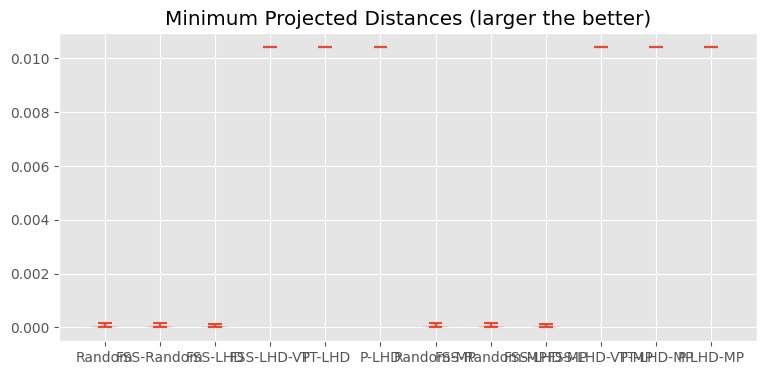

[[0.0002113814971309788, 0.0004346688536302351, 0.00022275718321473903, 0.0003672321422647229, 0.00032199879625331024, 0.00030114226610481604, 0.00034220876793555205, 0.00011700458183315499, 0.00028049454346622954, 0.00018701717841926313, 0.0005561530670953191, 0.0001597271016407914, 0.00011913526086447523, 0.00016473177101552355, 0.0002939822222824892, 0.0002201196215577128, 0.0003366397425329237, 9.156036123142419e-05, 0.00033075686353187944, 0.00024267087788235747, 0.0005243752654628259, 0.0005769440608386009, 0.00025570410886151945, 0.00027516676120859646, 0.0001343327014410728, 0.00017193668007507712, 0.0003477615974669529, 0.00023694899434111016, 0.0001407021660472657, 0.00029351815938509496], [0.0003212623862095809, 0.0002624675798262588, 0.00022621922613098866, 8.482413093698071e-05, 0.00023810359765498446, 0.0002377518221252789, 0.00021575007232843557, 0.00015060173605617455, 0.00040947220582583654, 0.00028178812026719013, 0.0001887380845808223, 0.00024371384599190804, 0.00021

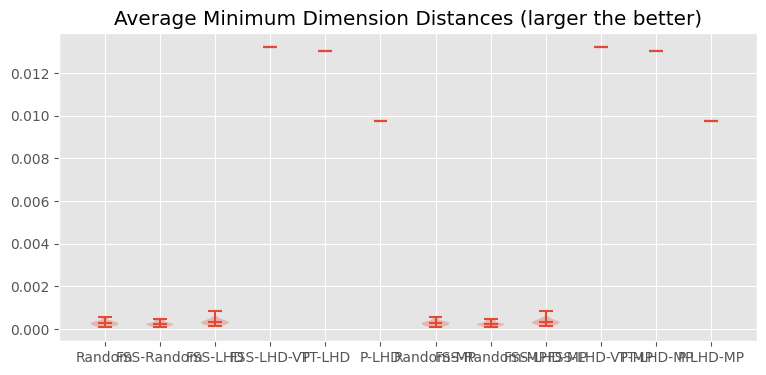

In [34]:
generate_basic_plots(assessment_modest_heirarchy.problem_size_results[96])

In [35]:
plot_designs(assessment_simple_heirarchy.problem_size_results[64],design_index =1)

KeyError: 64

In [36]:
peek_into_results(assessment_simple_heirarchy.problem_size_results[64])

KeyError: 64

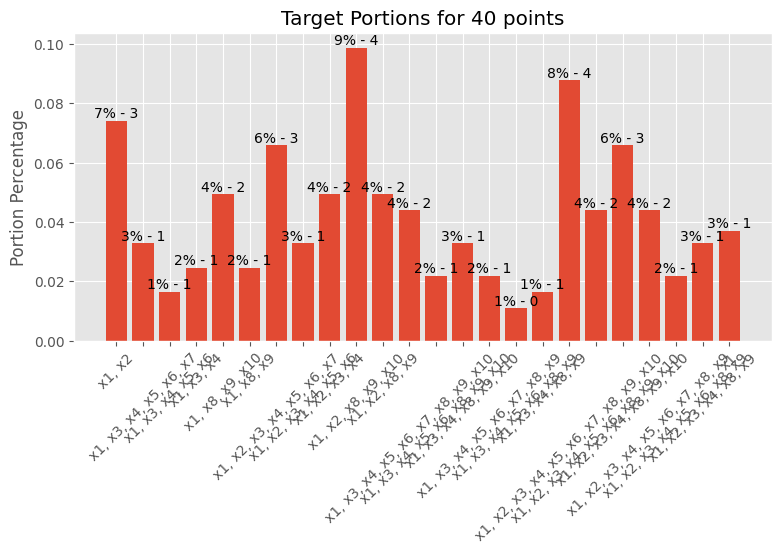

In [37]:
assessment_complex_heirarchy = AssessmentSet.Initalize(
    assessment_name="complex_heirarchy",
    strategies=strategies,
    input_space = s.InputSpace(
        dimensions=[
            s.Float(id="x1", lb=0.0, ub=1.0, portion_null=0.0),
            s.Float(
                id="x2",
                lb=0.0,
                ub=1.0,
                nullable=True,
                portion_null=1.0 / 3.0,
            ),
            s.Composite(
                id="x3",
                nullable=True,
                portion_null=1.0 / 3.0,
                children=[
                    s.Float(
                        id="x4",
                        lb=0.0,
                        ub=1.0,
                        portion_null=0.0,
                    ),
                    s.Composite(
                        id="x5",
                        nullable=True,
                        portion_null=1.0 / 3.0,
                        children=[
                            s.Float(
                                id="x6",
                                lb=0.0,
                                ub=1.0,
                                portion_null=0.0,
                            ),
                            s.Float(
                                id="x7",
                                lb=0.0,
                                ub=1.0,
                                nullable=True,
                                portion_null=1.0 / 3.0,
                            ),
                        ],
                    ),
                ],
            ),
            s.Composite(
                id="x8",
                nullable=True,
                portion_null=1.0 / 3.0,
                children=[
                    s.Float(
                        id="x9",
                        lb=0.0,
                        ub=1.0,
                        portion_null=0.0,
                    ),
                    s.Float(
                        id="x10",
                        lb=0.0,
                        ub=1.0,
                        nullable=True,
                        portion_null=1.0 / 3.0,
                    ),
                ],
            ),
            # s.Variant(
            #      id="x11",
            #      nullable=True,
            #      portion_null=0.33,
            #      options=[
            #          s.Float(id="x12", lb=0.0, ub=1.0, portion_null=0.0),
            #          s.Float(id="x13", lb=0.0, ub=1.0, portion_null=0.0),
            #      ],
            # ),
        ]
    )
)

plot_fullsubspace_target_portions(assessment_complex_heirarchy.input_space, number_of_points=10*4)

In [38]:
assessment_complex_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(10*4,),
)

At least some results exist for 40.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [39]:
assessment_complex_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(10*4*2,),
)

At least some results exist for 80.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [40]:
assessment_complex_heirarchy.generate_designs(
    number_of_designs=30,
    set_points=(10*4*3,),
)

At least some results exist for 120.
Skipping designs for strategy: 'Random', already exists.
Skipping designs for strategy: 'FSS-Random', already exists.
Skipping designs for strategy: 'FSS-LHD', already exists.
Skipping designs for strategy: 'FSS-LHD-VP', already exists.
Skipping designs for strategy: 'TT-LHD', already exists.
Skipping designs for strategy: 'P-LHD', already exists.
Skipping designs for strategy: 'Random-MP', already exists.
Skipping designs for strategy: 'FSS-Random-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-MP', already exists.
Skipping designs for strategy: 'FSS-LHD-VP-MP', already exists.
Skipping designs for strategy: 'TT-LHD-MP', already exists.
Skipping designs for strategy: 'P-LHD-MP', already exists.


In [ ]:
def generate_group_assessment_plot_diff(metric, assessments:List[AssessmentSet], strategies1:List[DesignStrategy], strategies2:List[DesignStrategy]):

    # Group labels for the x-axis
    group_labels = []
    groups = []

    for assessment in assessments:
        for problem_size, results in assessment.problem_size_results.items():
            group_labels.append(f"{assessment.assessment_name}({problem_size})")
            max_v = -np.inf
            min_v = np.inf
            group_data = []
            for strategy1, strategy2 in zip(strategies1,strategies2):
                values = []
                for r1 in results:
                    if r1.name == strategy1.name:
                        break
                for r2 in results:
                    if r2.name == strategy2.name:
                        break
                for doe_tuple1, doe_tuple2 in zip(r1.results, r2.results):
                    value1 = doe_tuple1.measurement_set.measurements[metric]
                    value2 = doe_tuple2.measurement_set.measurements[metric]
                    value = value2 - value1
                    if value > max_v:
                        max_v = value
                    if value < min_v:
                        min_v = value
                    values.append(value)
                group_data.append(np.array(values))
            # normalize

            if min_v < 0:
                if max_v > abs(min_v):
                    min_v = max_v * -1
            elif min_v > 0:
                min_v = 0
            if max_v < 0:
                max_v = 0.0

            for data in group_data:
                data[:] = data  /abs(max_v - min_v)
            groups.append(group_data)

    # Data as [problem1 Strategy 1, problem 2  stragey 2], [Group B1, Group B2]
    all_data = []
    positions = []
    x_ticks = []
    x_tick_labels = []
    p_index = 0
    color_map = [(1,0,0), (0.8,0,0), (0.6,0,0),
                 (0,1,0), (0,0.8,0), (0,0.6,0),
                 (0,0,1), (0,0,0.8), (0,0,0.6),
                 (1,1,0), (0.8,0.8,0), (0.6,0.6,0)]
    colors = []
    for i, strategy in enumerate(strategies1):
        p_index += 2
        x_ticks.append(p_index + len(groups)/2 - 0.5)
        x_tick_labels.append(strategy.name)
        for j, group_data in enumerate(groups):
            colors.append(color_map[j])
            positions.append(p_index)
            data = group_data[i]
            all_data.append(data)
            p_index += 1


    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    # Grouped boxplot
    box = ax.boxplot(all_data, patch_artist=True, positions=positions)

    # Add colors to differentiate between groupings
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Adding a legend for the groupings
    handles = list(plt.Line2D([0], [0], color=color, lw=4, label=lbl) for color, lbl in zip(colors, group_labels))

    ax.legend(handles=handles,loc='center left',title="Input Space (problem size)", bbox_to_anchor=(1,0.5))


    # Adjust the x-axis labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    # Adding title and labels
    #ax.set_title('Grouped Boxplot with Additional Grouping Factor')
    ax.set_xlabel('Design Algorithm')
    ax.set_ylabel('Normalized Difference')

    for i in range(1,len(strategies1)):
        plt.axvline(x=len(groups)*i+2*i+0.5, color='black', linestyle='--', lw=1)


    # Adjust layout to fit legend
    plt.tight_layout(rect=(0, 0, 0.9, 1))  # Make space for the legend on the right


    # Display the plot
    plt.show()

In [ ]:
def generate_group_assessment_plot(metric, assessments:List[AssessmentSet], strategies:List[DesignStrategy]):

    # Group labels for the x-axis
    group_labels = []
    groups = []

    for assessment in assessments:
        for problem_size, results in assessment.problem_size_results.items():
            group_labels.append(f"{assessment.assessment_name}({problem_size})")
            max_v = -np.inf
            min_v = np.inf
            group_data = []
            for strategy in strategies:
                values = []
                for r in results:
                    if r.name == strategy.name:
                        break
                for doe_tuple in r.results:
                    value = doe_tuple.measurement_set.measurements[metric]
                    if value > max_v:
                        max_v = value
                    if value < min_v:
                        min_v = value
                    values.append(value)
                group_data.append(np.array(values))
            # normalize
            for data in group_data:
                data[:] = (data - min_v)  /(max_v - min_v)
            groups.append(group_data)

    # Data as [problem1 Strategy 1, problem 2  stragey 2], [Group B1, Group B2]
    all_data = []
    positions = []
    x_ticks = []
    x_tick_labels = []
    p_index = 0
    color_map = [(1,0,0), (0.8,0,0), (0.6,0,0),
                 (0,1,0), (0,0.8,0), (0,0.6,0),
                 (0,0,1), (0,0,0.8), (0,0,0.6),
                 (1,1,0), (0.8,0.8,0), (0.6,0.6,0)]
    colors = []
    for i, strategy in enumerate(strategies):
        p_index += 2
        x_ticks.append(p_index + len(groups)/2 - 0.5)
        x_tick_labels.append(strategy.name)
        for j, group_data in enumerate(groups):
            colors.append(color_map[j])
            positions.append(p_index)
            data = group_data[i]
            all_data.append(data)
            p_index += 1


    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    # Grouped boxplot
    box = ax.boxplot(all_data, patch_artist=True, positions=positions)

    # Add colors to differentiate between groupings
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Adding a legend for the groupings
    handles = list(plt.Line2D([0], [0], color=color, lw=4, label=lbl) for color, lbl in zip(colors, group_labels))

    ax.legend(handles=handles,loc='center left',title="Input Space (problem size)", bbox_to_anchor=(1,0.5))


    # Adjust the x-axis labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, rotation=45)

    # Adding title and labels
    #ax.set_title('Grouped Boxplot with Additional Grouping Factor')
    ax.set_xlabel('Design Algorithm')
    ax.set_ylabel('Normalized Value')

    for i in range(1,len(strategies)):
        plt.axvline(x=len(groups)*i+2*i+0.5, color='black', linestyle='--', lw=1)


    # Adjust layout to fit legend
    plt.tight_layout(rect=(0, 0, 1, 1))  # Make space for the legend on the right


    plt.savefig('my_figure.png', dpi=600) # Set DPI during saving
    # Display the plot
    plt.show()

def generate_group_assessment_plot_allocation_counts(assessments:List[AssessmentSet], strategies:List[DesignStrategy]):

    # Group labels for the x-axis
    group_labels = []
    groups = []

    for assessment in assessments:
        for problem_size, results in assessment.problem_size_results.items():
            group_labels.append(f"{assessment.assessment_name}({problem_size})")
            max_v = -np.inf
            min_v = np.inf
            group_data = []
            for strategy in strategies:
                values = []
                for r in results:
                    if r.name == strategy.name:
                        break
                for doe_tuple in r.results:
                    value = doe_tuple.measurement_set.measurements[metric]
                    if value > max_v:
                        max_v = value
                    if value < min_v:
                        min_v = value
                    values.append(value)
                group_data.append(np.array(values))
            # normalize
            for data in group_data:
                data[:] = (data - min_v)  /(max_v - min_v)
            groups.append(group_data)

    # Data as [problem1 Strategy 1, problem 2  stragey 2], [Group B1, Group B2]
    all_data = []
    positions = []
    x_ticks = []
    x_tick_labels = []
    p_index = 0
    color_map = [(1,0,0), (0.8,0,0), (0.6,0,0),
                 (0,1,0), (0,0.8,0), (0,0.6,0),
                 (0,0,1), (0,0,0.8), (0,0,0.6),
                 (1,1,0), (0.8,0.8,0), (0.6,0.6,0)]
    colors = []
    for i, strategy in enumerate(strategies):
        p_index += 2
        x_ticks.append(p_index + len(groups)/2 - 0.5)
        x_tick_labels.append(strategy.name)
        for j, group_data in enumerate(groups):
            colors.append(color_map[j])
            positions.append(p_index)
            data = group_data[i]
            all_data.append(data)
            p_index += 1


    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    # Grouped boxplot
    box = ax.boxplot(all_data, patch_artist=True, positions=positions)

    # Add colors to differentiate between groupings
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Adding a legend for the groupings
    handles = list(plt.Line2D([0], [0], color=color, lw=4, label=lbl) for color, lbl in zip(colors, group_labels))

    ax.legend(handles=handles,loc='center left',title="Input Space (problem size)", bbox_to_anchor=(1,0.5))


    # Adjust the x-axis labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, rotation=45)

    # Adding title and labels
    #ax.set_title('Grouped Boxplot with Additional Grouping Factor')
    ax.set_xlabel('Design Algorithm')
    ax.set_ylabel('Normalized Value')

    for i in range(1,len(strategies)):
        plt.axvline(x=len(groups)*i+2*i+0.5, color='black', linestyle='--', lw=1)


    # Adjust layout to fit legend
    plt.tight_layout(rect=(0, 0, 1, 1))  # Make space for the legend on the right


    plt.savefig('my_figure.png', dpi=600) # Set DPI during saving
    # Display the plot
    plt.show()

In [53]:
assessments = [
    basic_assessment,
    assessment_simple_heirarchy,
    assessment_modest_heirarchy,
    assessment_complex_heirarchy
]

strategies_w_mp = list(s for s in strategies if s.name.find("MP") >= 0)
strategies_wo_mp = list(s for s in strategies if s.name.find("MP") < 0)
strategies_fss = list(s for s in strategies if s.name.find("FSS") >= 0)

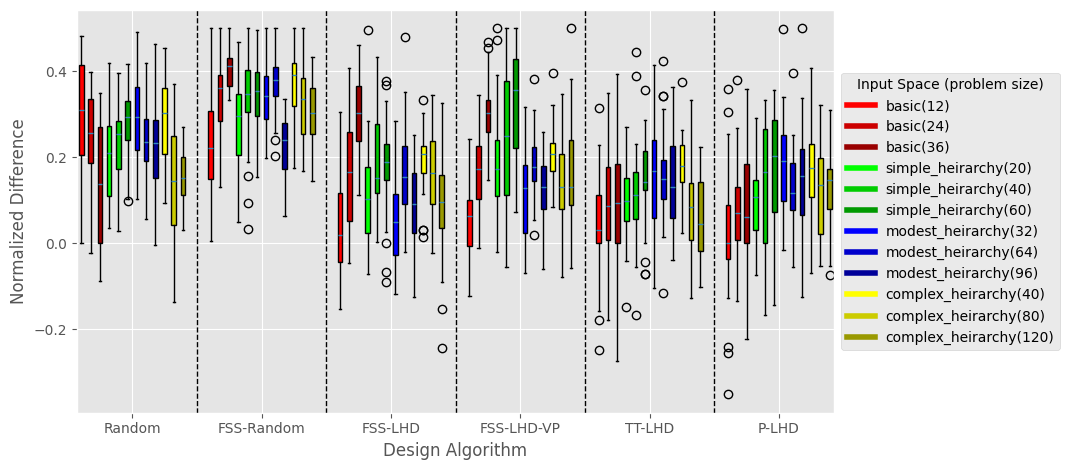

In [ ]:

generate_group_assessment_plot_diff(measure.METRIC_WHOLE_MIN_POINT_DISTANCE, assessments,strategies_wo_mp, strategies_w_mp)

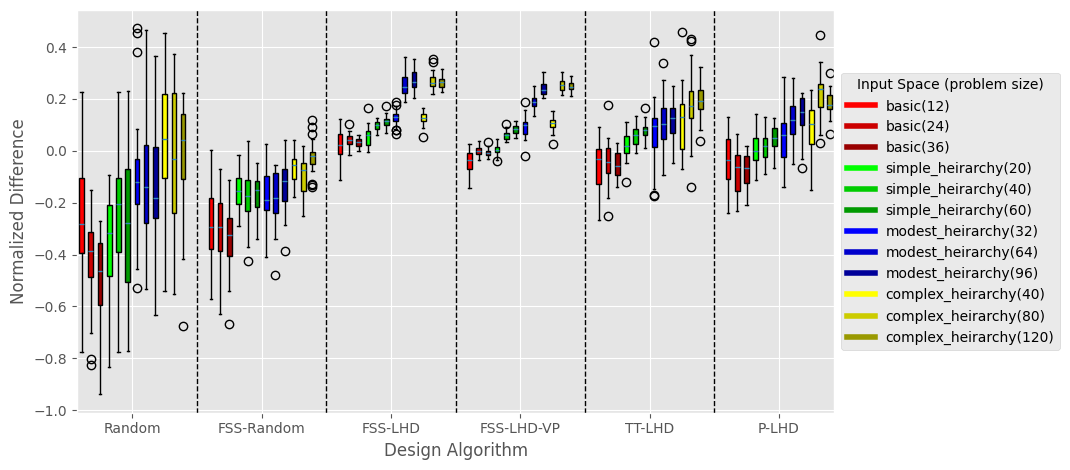

In [45]:
generate_group_assessment_plot_diff(measure.METRIC_WEIGHTED_DISCREPANCY, assessments,strategies_wo_mp, strategies_w_mp)

In [59]:

generate_group_assessment_plot_diff(measure.METRIC_PORTION_SUBSPACES_INCLUDED, assessments,strategies_wo_mp, strategies_w_mp)

KeyError: 'portion_of_subspaces_included'

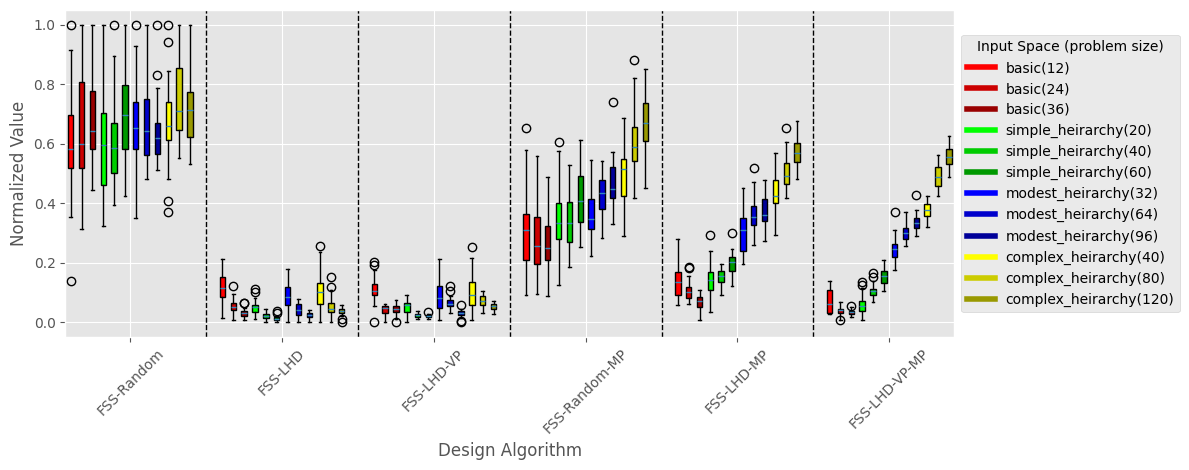

In [70]:
generate_group_assessment_plot(measure.METRIC_WEIGHTED_DISCREPANCY, assessments, strategies_fss)

In [62]:
plt.savefig('fss_designs_m_wdsr.png', dpi=600) # Set DPI during saving

<Figure size 640x480 with 0 Axes>

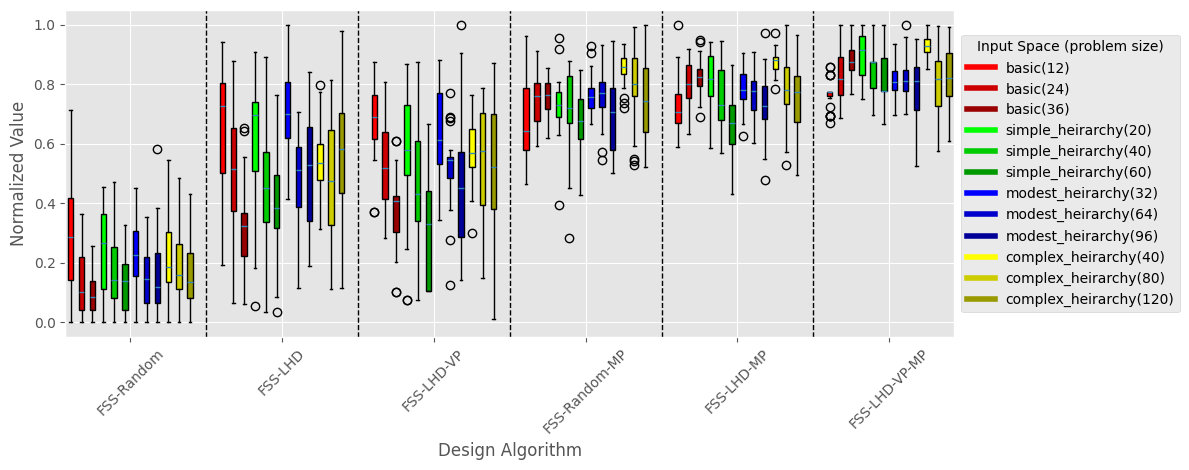

In [71]:
generate_group_assessment_plot(measure.METRIC_WHOLE_MIN_POINT_DISTANCE, assessments, strategies_fss)

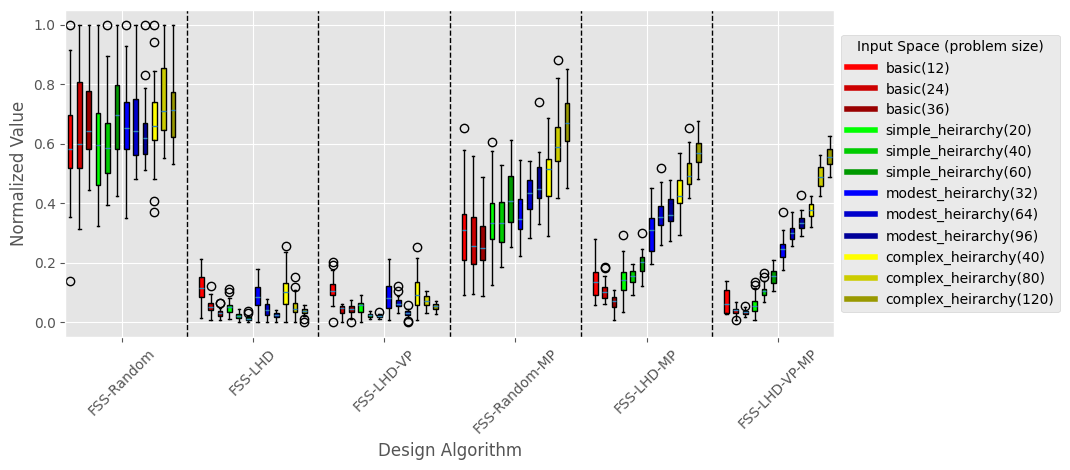

In [49]:
generate_group_assessment_plot(measure.METRIC_WEIGHTED_DISCREPANCY, assessments, list(strategy for strategy in strategies if strategy.name.find("FSS") >= 0))

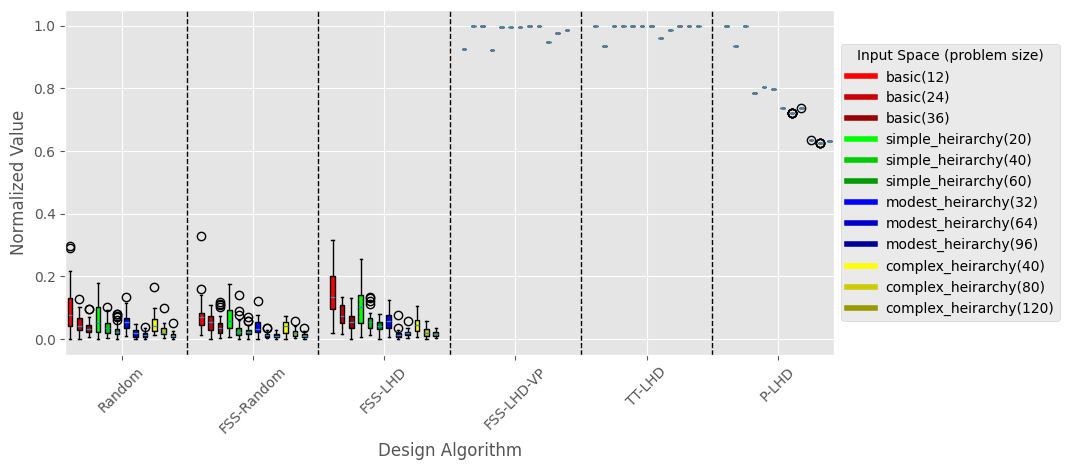

In [50]:
generate_group_assessment_plot(measure.METRIC_AVG_MIN_PROJECTED_DISTANCE, assessments, list(strategy for strategy in strategies if strategy.name.find("MP") < 0))

In [51]:
peek_into_results(strategies_ch_2)

NameError: name 'strategies_ch_2' is not defined

In [ ]:
generate_basic_plots(strategies_ch_2)

In [60]:
plot_fullsubspace_target_portions(space_ch,number_of_points=30)

NameError: name 'space_ch' is not defined

In [ ]:
plot_designs(strategies_ch_2,design_index =1)